In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [4]:
from src.load_data import load_data

epoch_key = "con", 3, 4

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


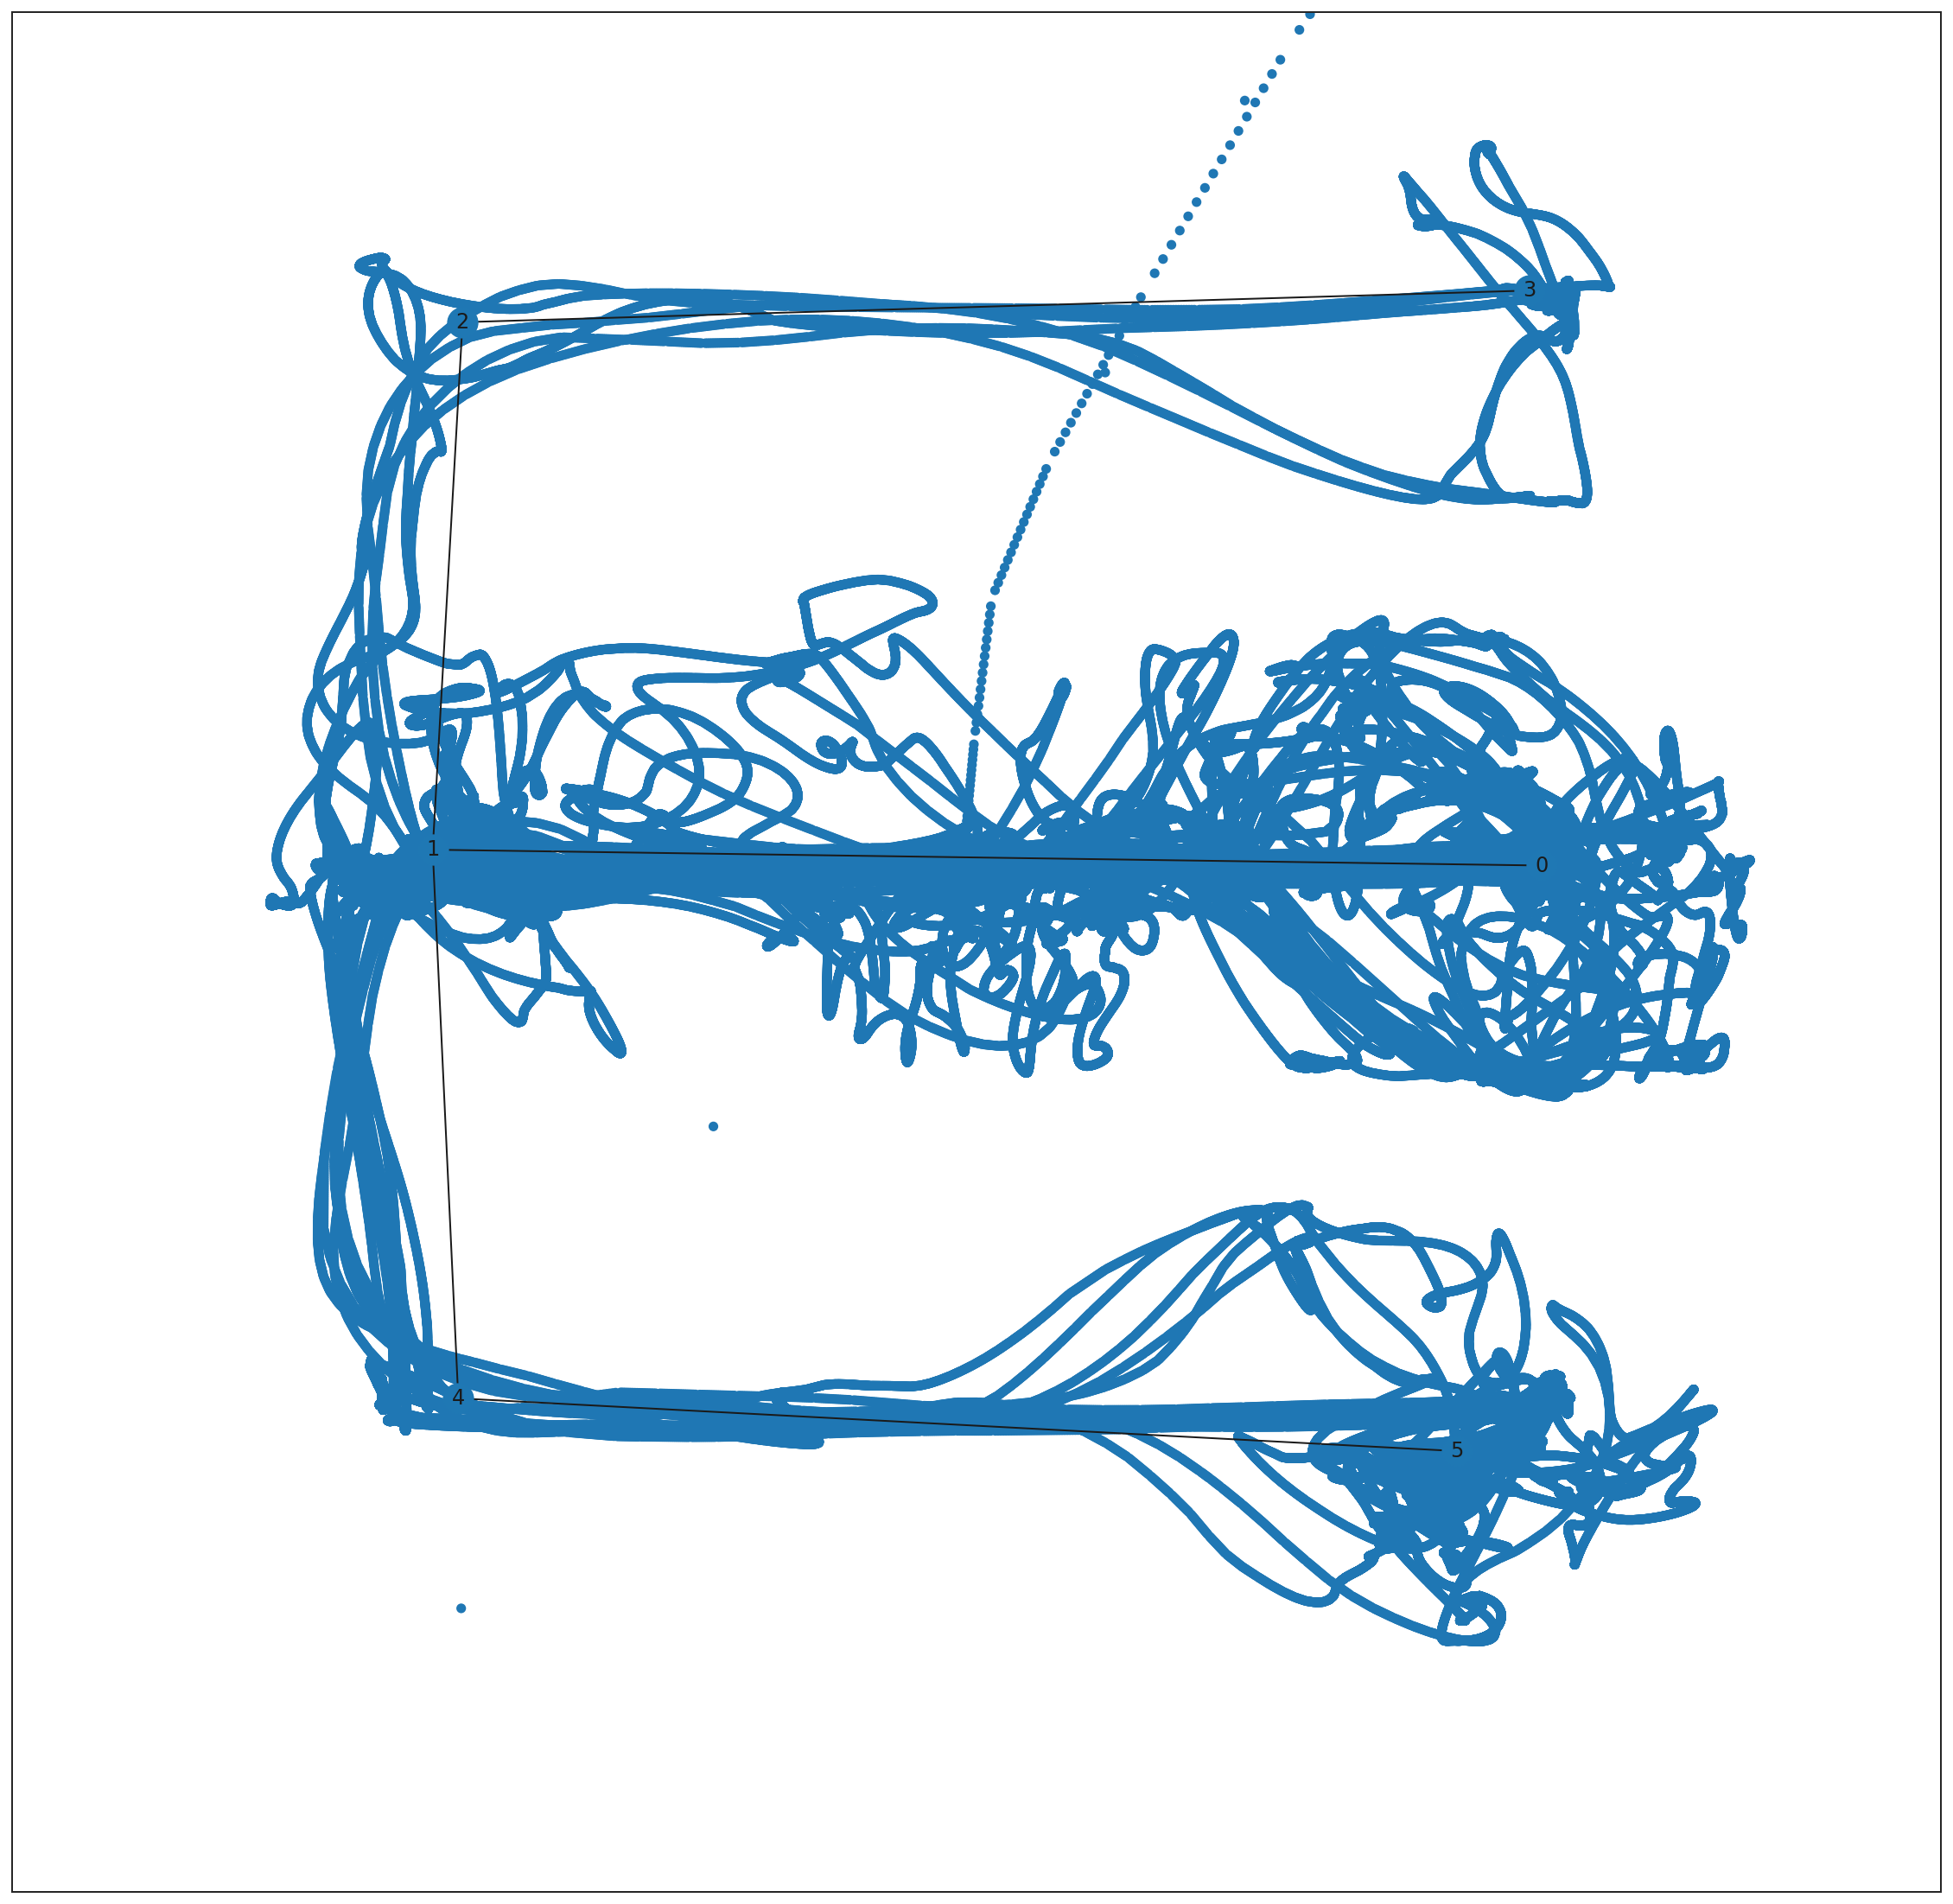

In [20]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    data["position_info"].x_position,
    data["position_info"].y_position,
    c=data["position_info"].track_segment_id,
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((0, 125))
plt.ylim((0, 125))
plot_track(track_graph)

In [18]:
data["position_info"].track_segment_id.unique()

array([2., 0.])

In [21]:
from loren_frank_data_processing import get_position_dataframe

position_df = get_position_dataframe(epoch_key, ANIMALS, skip_linearization=False)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


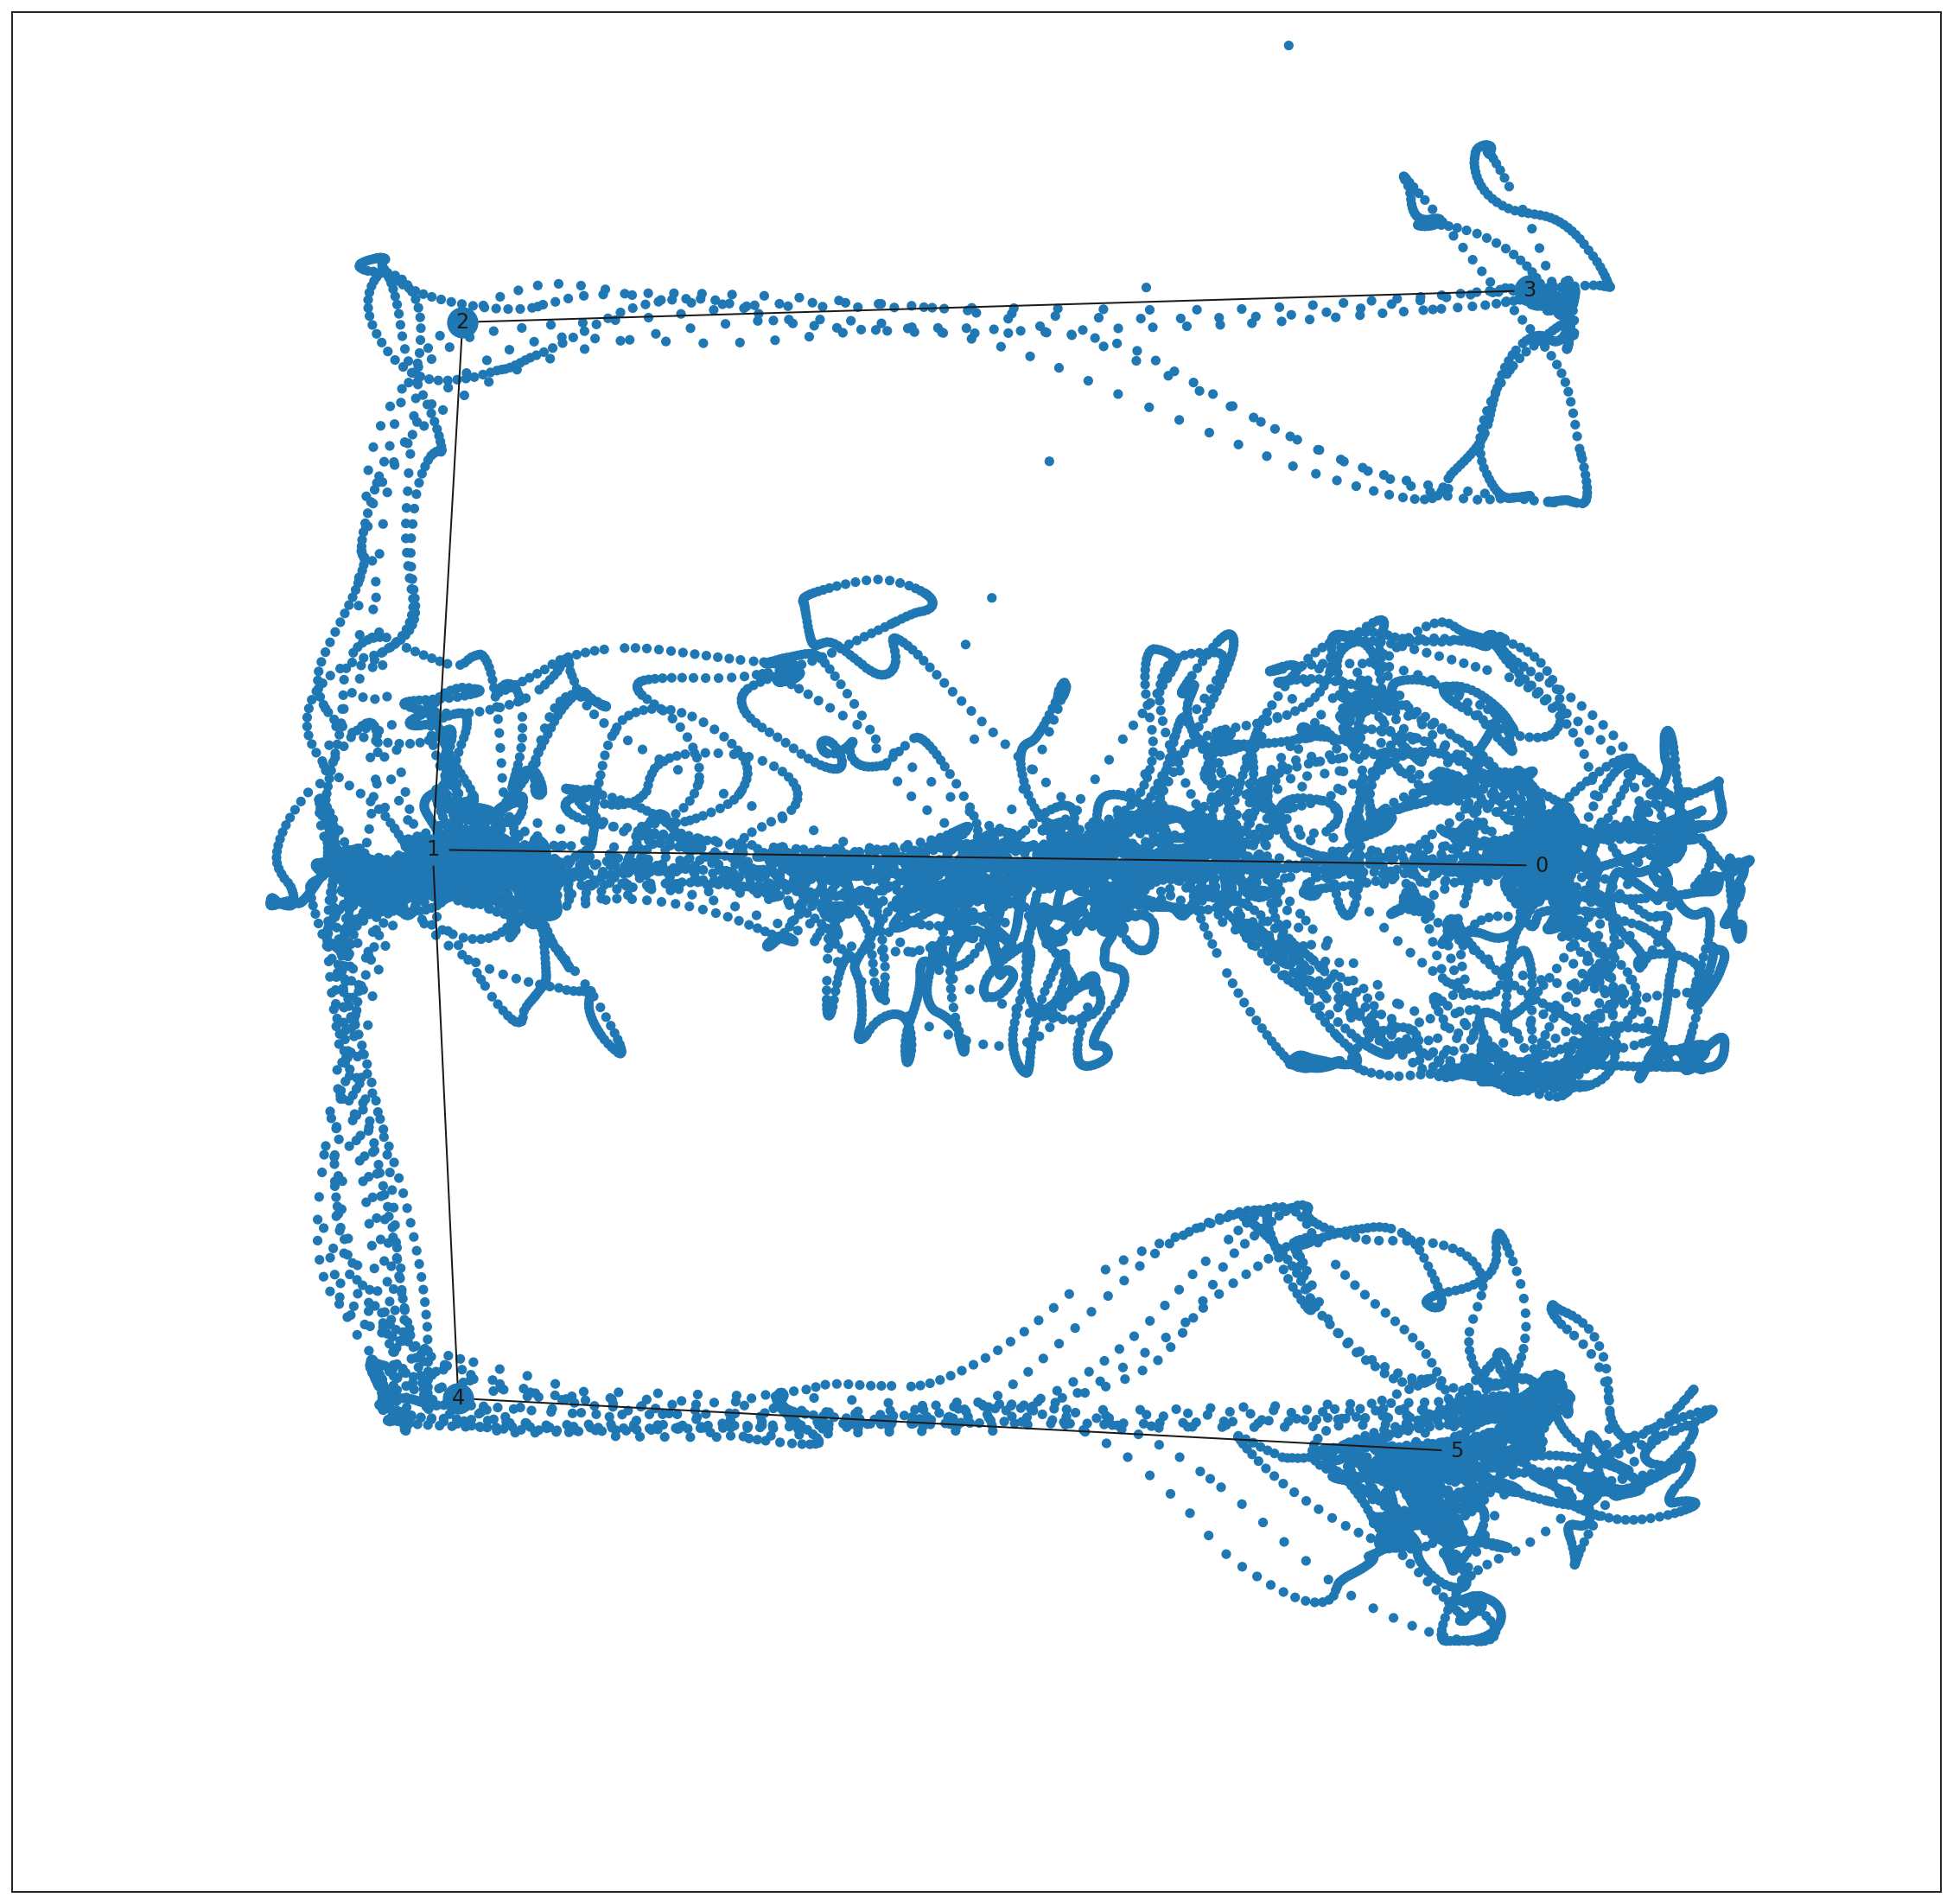

In [22]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    position_df.x_position,
    position_df.y_position,
    c=position_df.track_segment_id,
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((0, 125))
plt.ylim((0, 125))
plot_track(track_graph)

In [24]:
track_graph.edges(data=True)

EdgeDataView([(0, 1, {'distance': 71.89710702188248}), (1, 2, {'distance': 35.14106064658912}), (1, 4, {'distance': 36.528919518633224}), (2, 3, {'distance': 69.15647562737011}), (4, 5, {'distance': 64.79553311767945})])

In [134]:
track_graph.nodes(data=True)

NodeDataView({0: {'pos': (99.12442396313364, 68.24561403508773)}, 1: {'pos': (27.235023041474655, 69.2982456140351)}, 2: {'pos': (29.1705069124424, 104.38596491228071)}, 3: {'pos': (98.29493087557606, 106.49122807017545)}, 4: {'pos': (28.894009216589865, 32.80701754385966)}, 5: {'pos': (93.59447004608296, 29.298245614035096)}})

In [126]:
from loren_frank_data_processing.position import (
    _get_pos_dataframe,
    make_track_graph,
    classify_track_segments,
)

route_euclidean_distance_scaling = 1e-1
sensor_std_dev = 10
diagonal_bias = 1e-1

position_df = _get_pos_dataframe(epoch_key, ANIMALS)
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
position = position_df.loc[:, ["x_position", "y_position"]].values

track_segment_id = classify_track_segments(
    track_graph,
    position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias,
)

In [127]:
np.unique(track_segment_id)

array([0.])

In [132]:
from loren_frank_data_processing.track_segment_classification import (
    calculate_empirical_state_transition,
    calculate_position_likelihood,
    viterbi,
)

n_segments = len(track_graph.edges)
initial_conditions = np.ones((n_segments,))
state_transition = calculate_empirical_state_transition(
    position,
    track_graph,
    scaling=route_euclidean_distance_scaling,
    diagonal_bias=diagonal_bias,
)
likelihood = calculate_position_likelihood(position, track_graph, sigma=sensor_std_dev)
state_transition[np.isclose(state_transition, 1.0)] = 1 - 0.2

track_segment_id = viterbi(initial_conditions, state_transition, likelihood)
np.unique(track_segment_id)

array([0.])

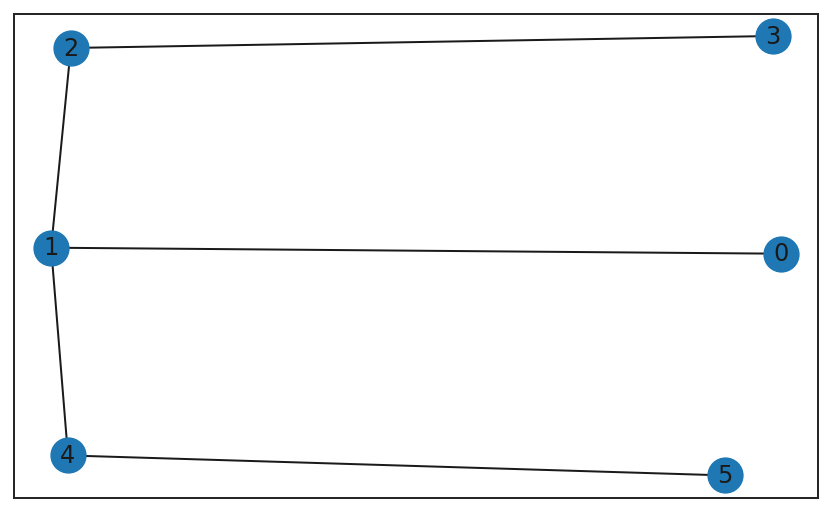

In [119]:
plot_track(track_graph)

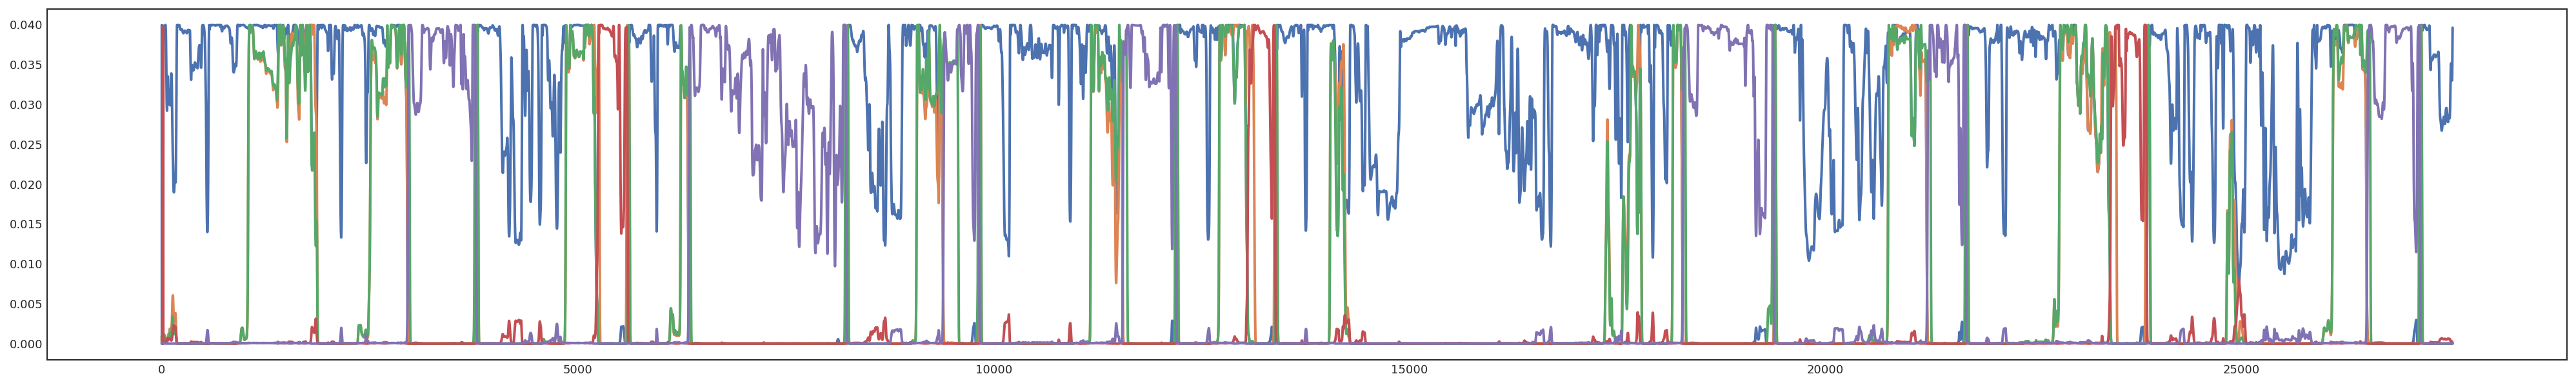

In [120]:
plt.figure(figsize=(35, 5))
plt.plot(likelihood, linewidth=2)

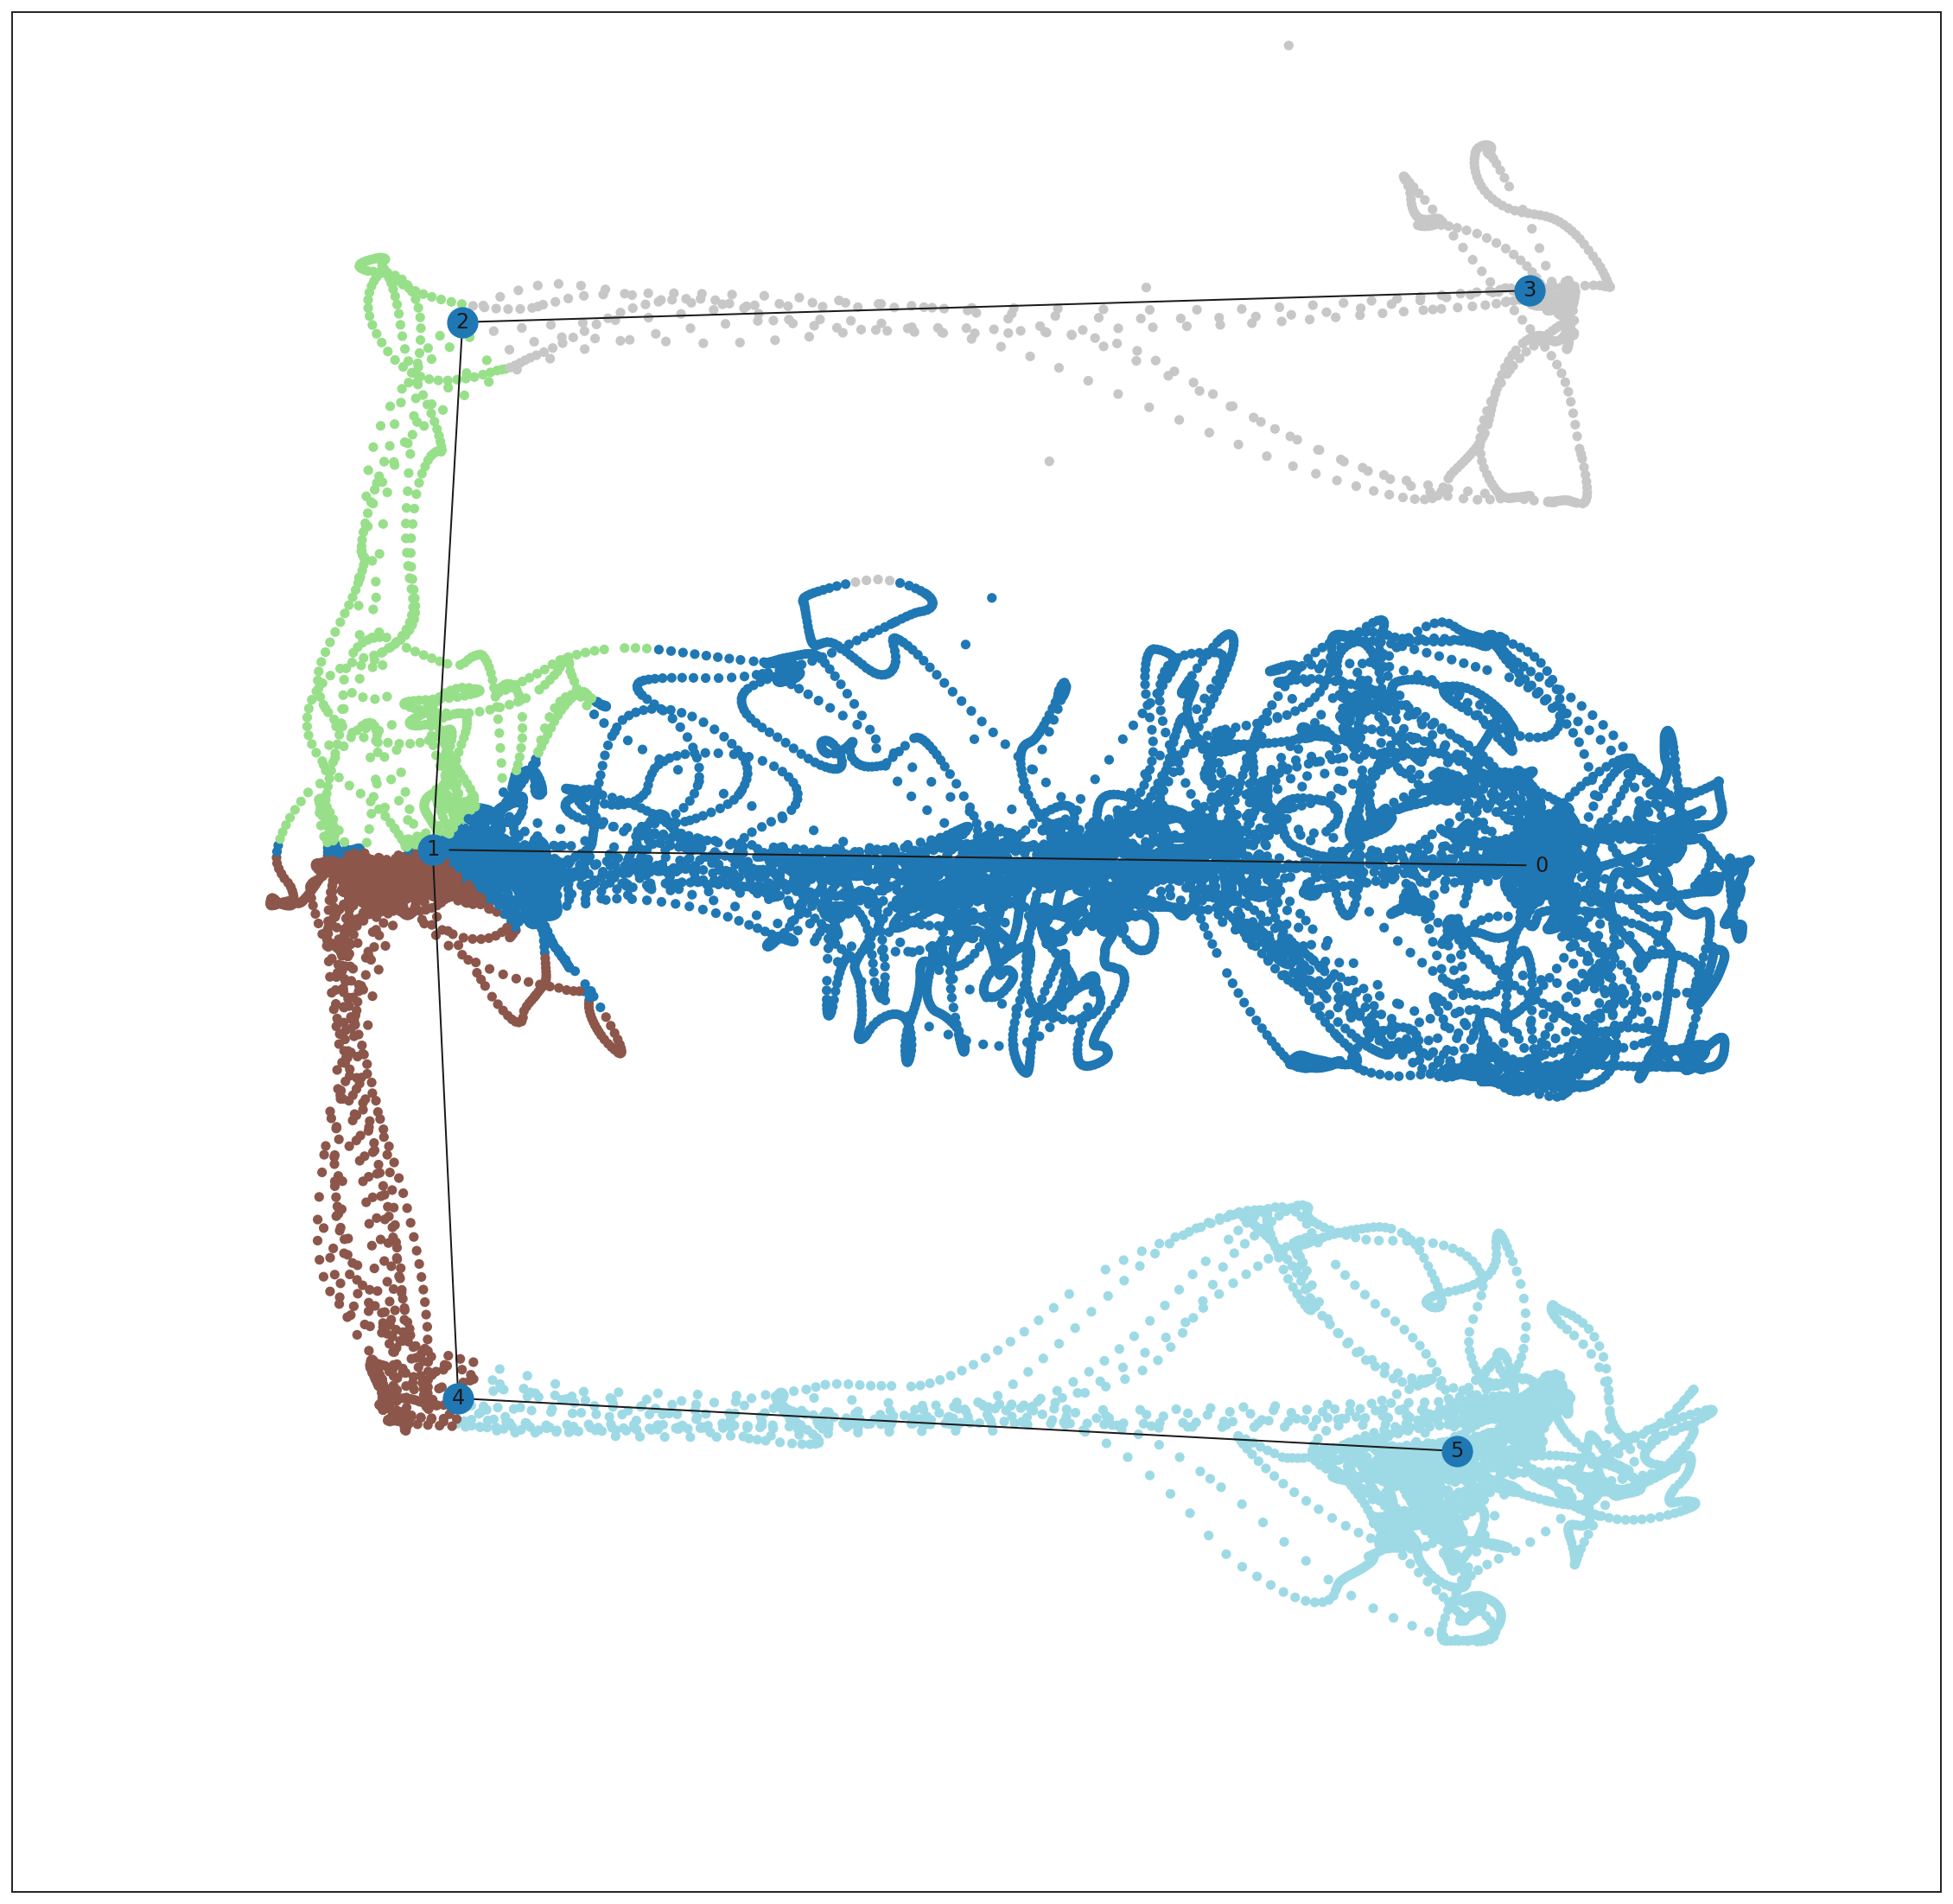

In [122]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    position_df.x_position,
    position_df.y_position,
    c=np.argmax(likelihood, axis=1),
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((0, 125))
plt.ylim((0, 125))
plot_track(track_graph)

(0, 5000)

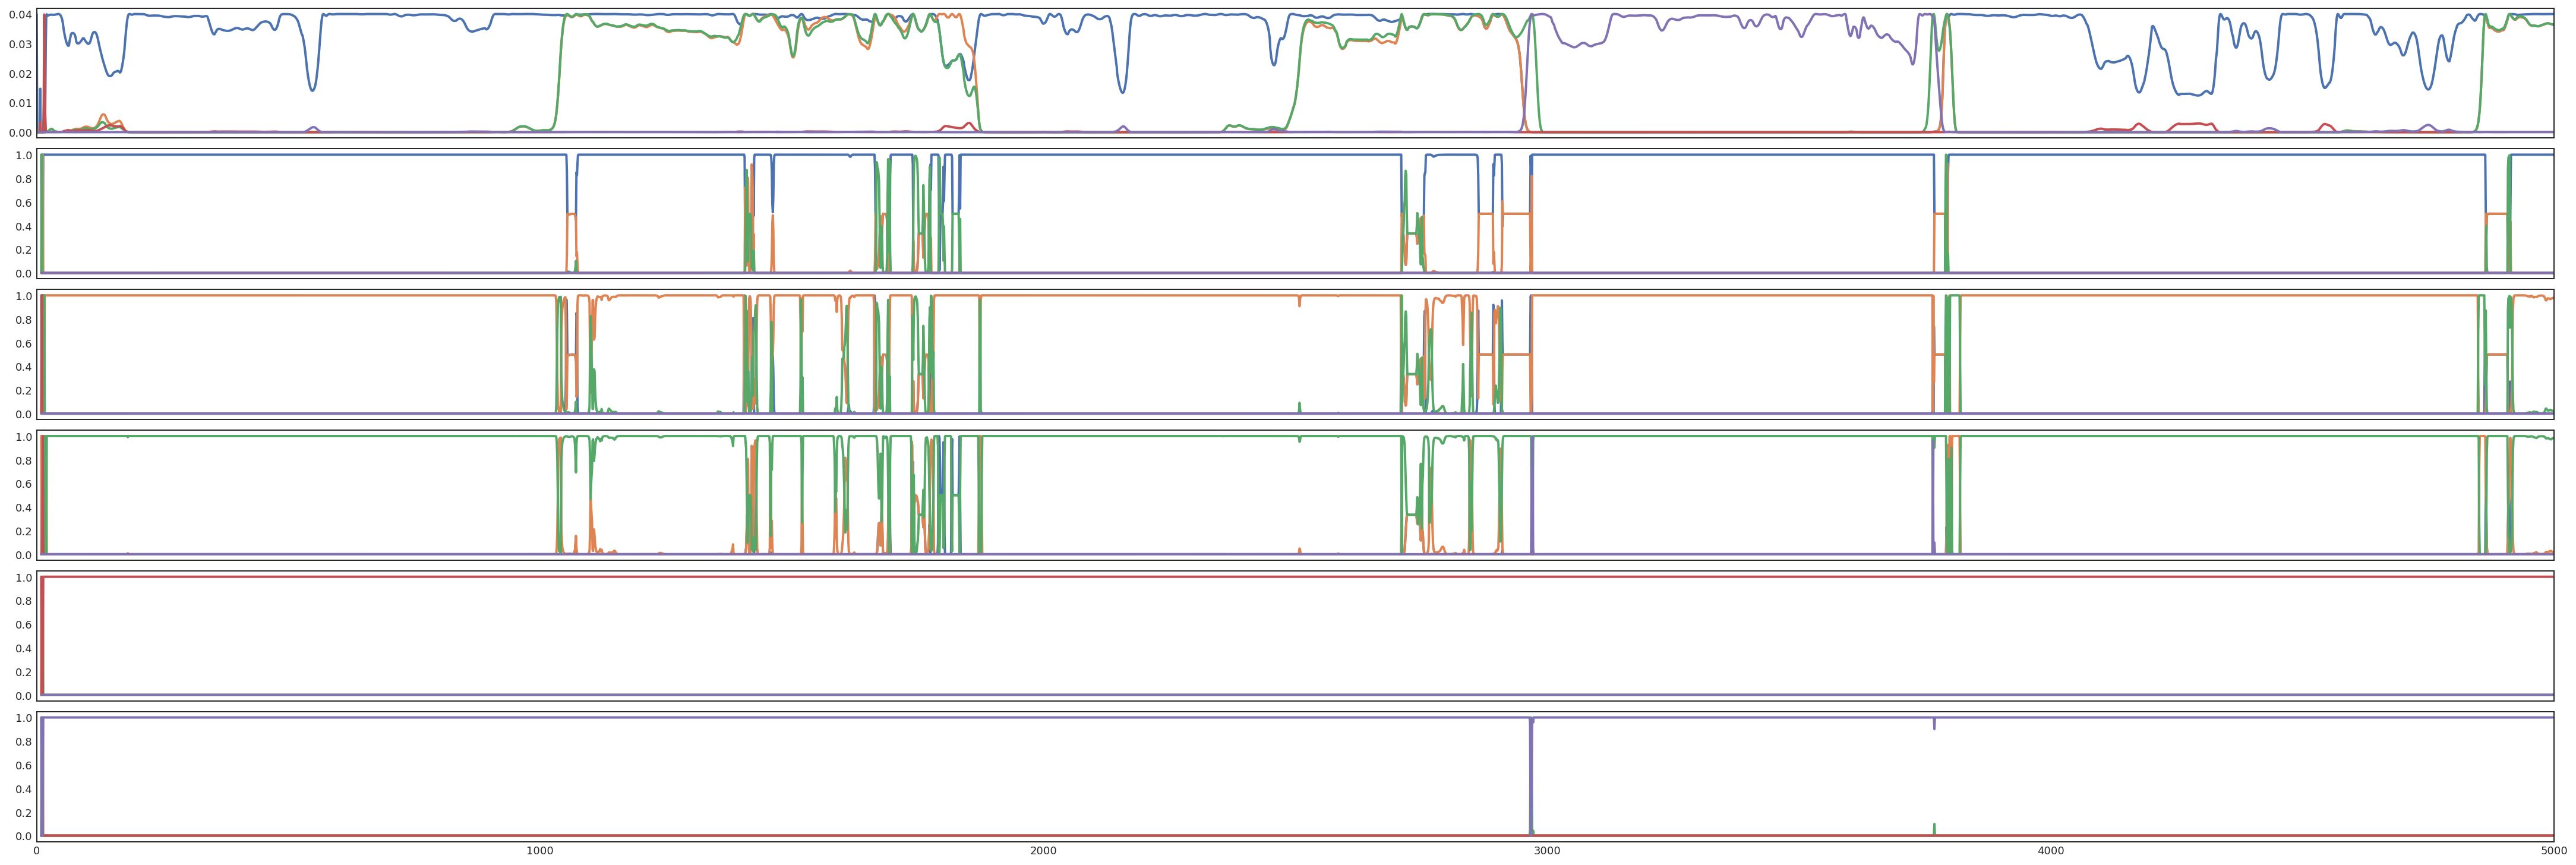

In [123]:
fig, axes = plt.subplots(6, 1, figsize=(30, 10), sharex=True, constrained_layout=True)
axes[0].plot(likelihood, linewidth=2)
for ind in range(5):
    axes[ind + 1].plot(state_transition[:, ind], linewidth=2)
plt.xlim((0, 5000))

In [142]:
pos = track_graph.nodes[4]["pos"]
track_graph.nodes[4]["pos"] = (pos[0] - 5, pos[1])

pos = track_graph.nodes[2]["pos"]
track_graph.nodes[2]["pos"] = (pos[0] - 5, pos[1])

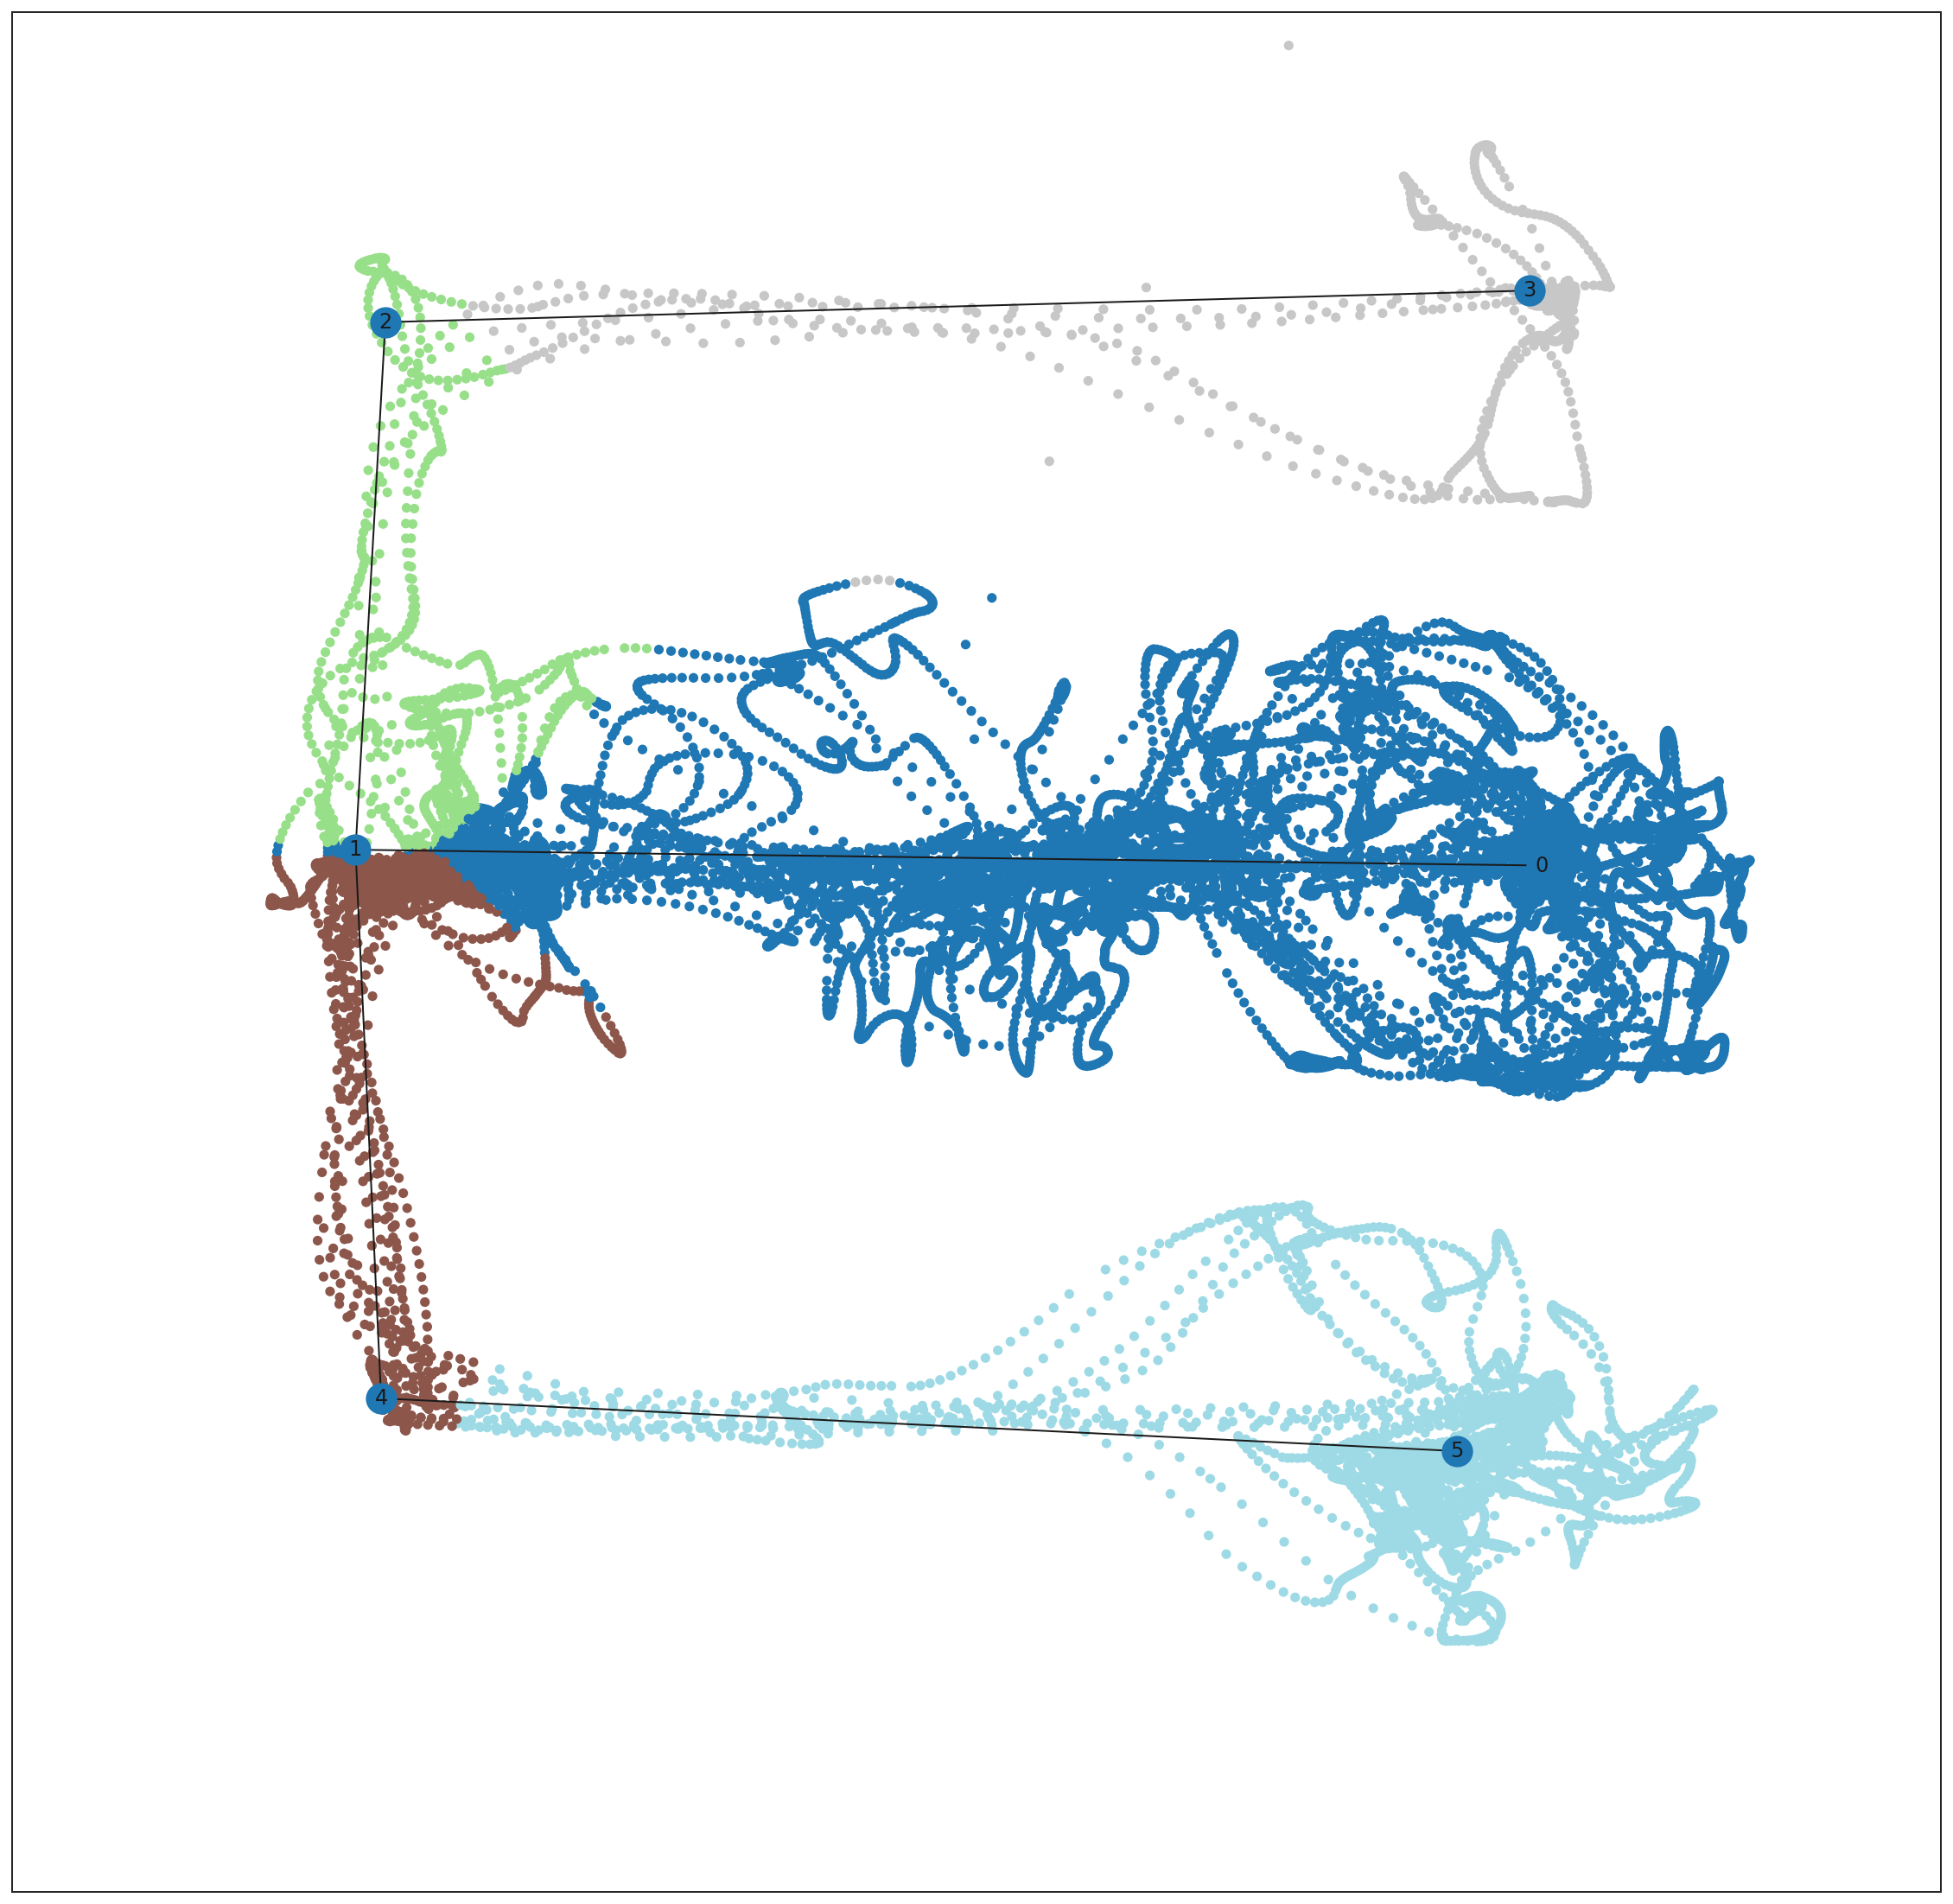

In [170]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph, get_track_segments
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    position_df.x_position,
    position_df.y_position,
    c=np.argmax(likelihood, axis=1),
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
pos = track_graph.nodes[4]["pos"]
track_graph.nodes[4]["pos"] = (pos[0] - 5, pos[1])
track_graph.edges[(4, 5)]["distance"] = track_graph.edges[(4, 5)]["distance"] + 5

pos = track_graph.nodes[2]["pos"]
track_graph.nodes[2]["pos"] = (pos[0] - 5, pos[1])
track_graph.edges[(2, 3)]["distance"] = track_graph.edges[(2, 3)]["distance"] + 5

pos = track_graph.nodes[1]["pos"]
track_graph.nodes[1]["pos"] = (pos[0] - 5, pos[1])
track_graph.edges[(0, 1)]["distance"] = track_graph.edges[(0, 1)]["distance"] + 5

plt.xlim((0, 125))
plt.ylim((0, 125))
plot_track(track_graph)

In [220]:
from loren_frank_data_processing.track_segment_classification import (
    calculate_empirical_state_transition,
    calculate_position_likelihood,
    viterbi,
)

route_euclidean_distance_scaling = 1
sensor_std_dev = 5
diagonal_bias = 1e-1


n_segments = len(track_graph.edges)
initial_conditions = np.ones((n_segments,))
state_transition = calculate_empirical_state_transition(
    position[11:],
    track_graph,
    scaling=route_euclidean_distance_scaling,
    diagonal_bias=diagonal_bias,
)
likelihood = calculate_position_likelihood(
    position[11:], track_graph, sigma=sensor_std_dev
)

track_segment_id = viterbi(initial_conditions, state_transition, likelihood)
np.unique(track_segment_id)

array([0., 1., 2., 3., 4.])

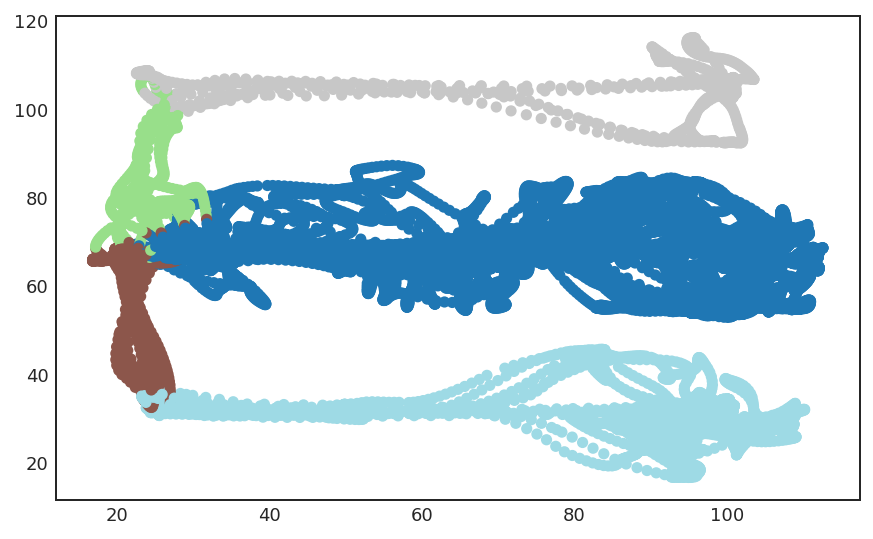

In [206]:
plt.scatter(position[20:, 0], position[20:, 1], c=track_segment_id, cmap=plt.cm.tab20)

In [221]:
from loren_frank_data_processing.track_segment_classification import (
    calculate_empirical_state_transition,
    calculate_position_likelihood,
    viterbi,
)

route_euclidean_distance_scaling = 1
sensor_std_dev = 5
diagonal_bias = 1e-1


n_segments = len(track_graph.edges)
initial_conditions = np.ones((n_segments,))
state_transition = calculate_empirical_state_transition(
    position,
    track_graph,
    scaling=route_euclidean_distance_scaling,
    diagonal_bias=diagonal_bias,
)
likelihood = calculate_position_likelihood(position, track_graph, sigma=sensor_std_dev)

track_segment_id = viterbi(initial_conditions, state_transition, likelihood)
np.unique(track_segment_id)

array([0.])

(0, 11)

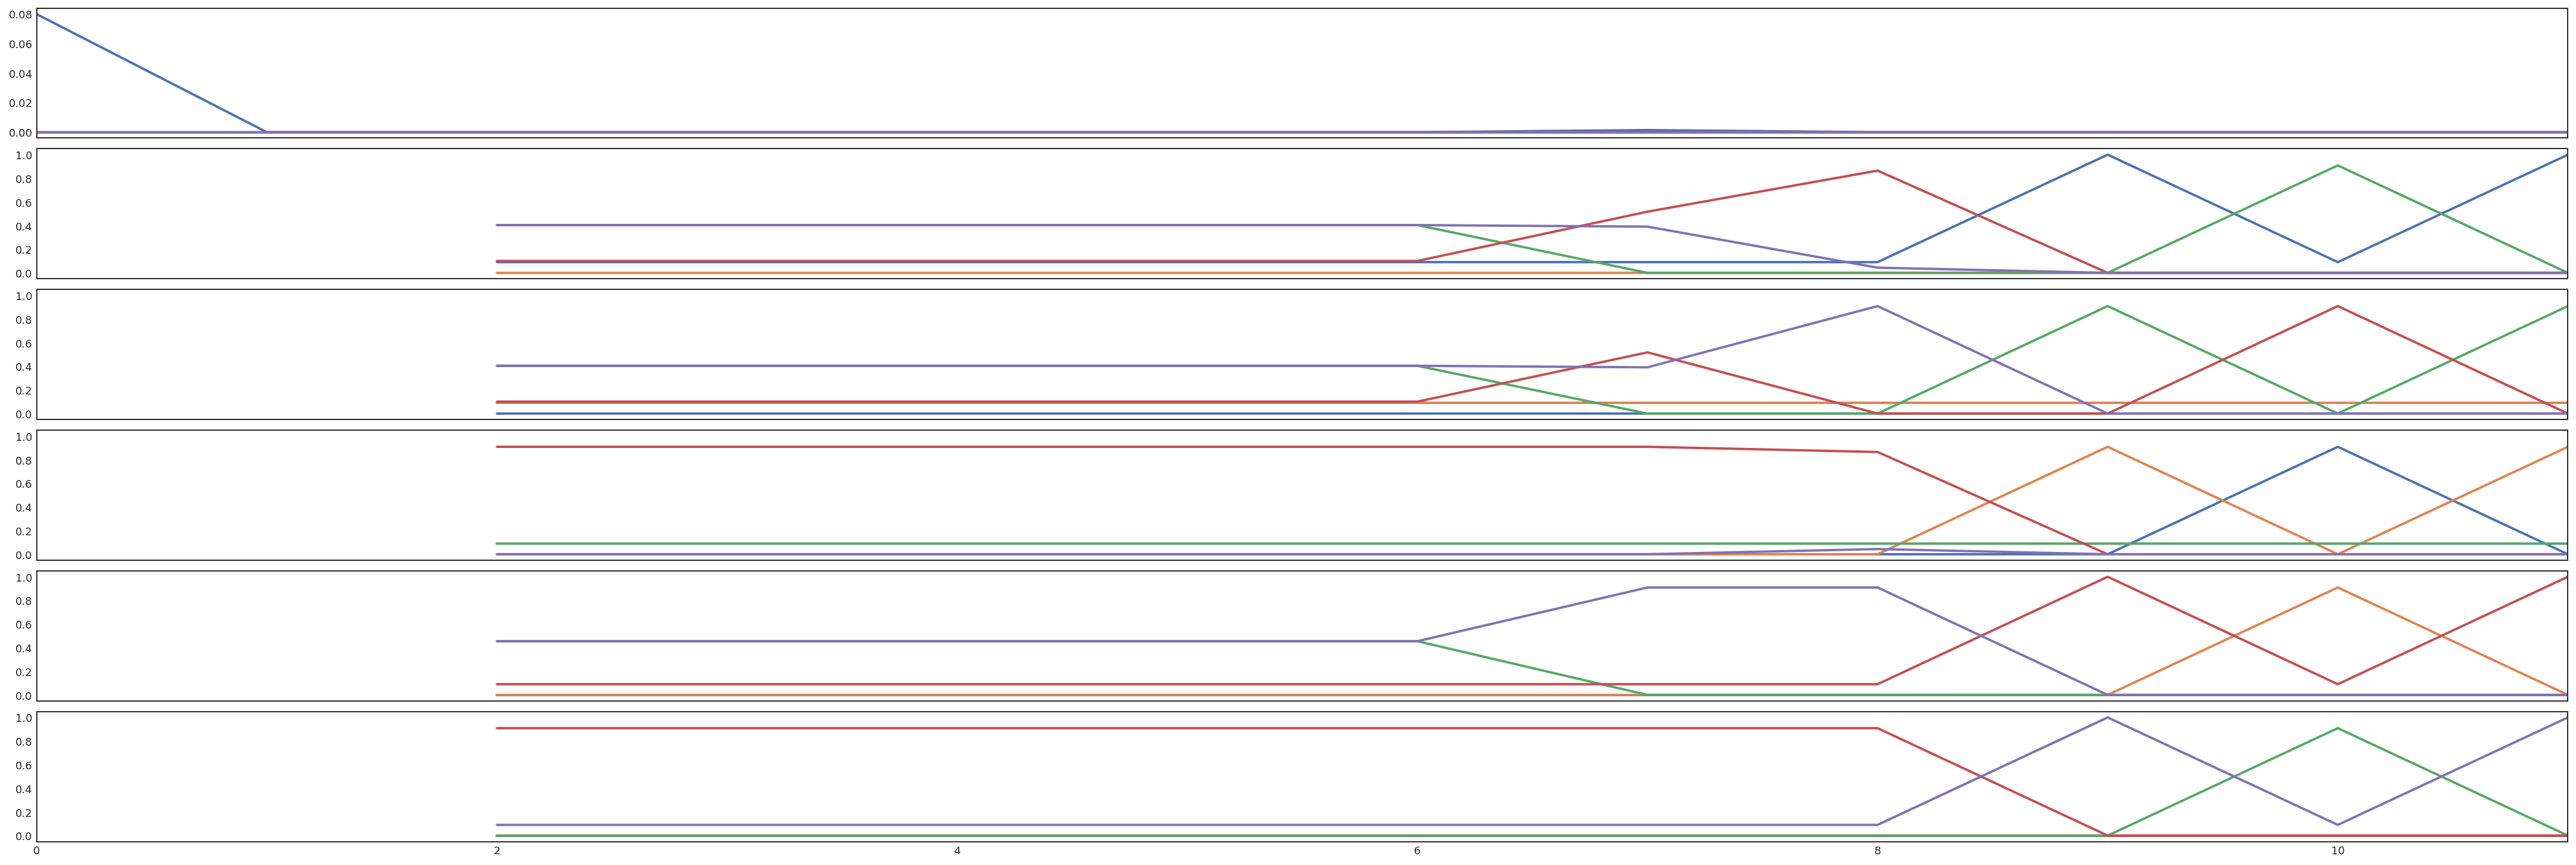

In [222]:
fig, axes = plt.subplots(6, 1, figsize=(30, 10), sharex=True, constrained_layout=True)
axes[0].plot(likelihood, linewidth=2)
for ind in range(5):
    axes[ind + 1].plot(state_transition[:, ind], linewidth=2)
plt.xlim((0, 11))

In [237]:
np.nonzero(np.any(np.isinf(np.log(likelihood[:20])), axis=1))

(array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11]),)

In [241]:
route_euclidean_distance_scaling = 1
sensor_std_dev = 5
diagonal_bias = 1e-1


def viterbi(initial_conditions, state_transition, likelihood):
    """Find the most likely sequence of paths using the Viterbi algorithm.

    Note that the state_transition matrix is time-dependent. NaNs are removed
    and placed back in at the end.

    Parameters
    ----------
    initial_conditions : ndarray, shape (n_states,)
    state_transition : ndarray, shape (n_time, n_states, n_states)
    likelihood : ndarray, shape (n_time, n_states)

    Returns
    -------
    state_id : ndarray, shape (n_time,)

    """
    is_bad = (
        np.any(np.isnan(likelihood), axis=1)
        | np.any(np.isnan(state_transition), axis=(1, 2))
        | np.any(np.isinf(np.log(likelihood)), axis=1)
    )
    log_likelihood = np.log(likelihood.copy()[~is_bad])
    state_transition = np.log(state_transition.copy()[~is_bad])

    n_time, n_states = log_likelihood.shape
    posterior = np.zeros((n_time, n_states))
    max_state_ind = np.zeros((n_time, n_states), dtype=np.int)

    # initialization
    posterior[0] = np.log(initial_conditions) + log_likelihood[0]

    # recursion
    for time_ind in range(1, n_time):
        prior = posterior[time_ind - 1] + state_transition[time_ind]
        max_state_ind[time_ind] = prior.argmax(axis=1)
        posterior[time_ind] = (
            prior[np.arange(n_states), max_state_ind[time_ind]]
            + log_likelihood[time_ind]
        )

    # termination
    most_probable_state_ind = np.zeros((n_time,), dtype=np.int)
    most_probable_state_ind[n_time - 1] = np.argmax(posterior[n_time - 1])

    # path back-tracking
    for time_ind in reversed(range(n_time - 1)):
        most_probable_state_ind[time_ind] = max_state_ind[
            time_ind + 1, most_probable_state_ind[time_ind + 1]
        ]

    most_probable_state_ind_with_nan = np.full((is_bad.size,), np.nan)
    most_probable_state_ind_with_nan[~is_bad] = most_probable_state_ind
    return most_probable_state_ind_with_nan


n_segments = len(track_graph.edges)
initial_conditions = np.ones((n_segments,))
state_transition = calculate_empirical_state_transition(
    position,
    track_graph,
    scaling=route_euclidean_distance_scaling,
    diagonal_bias=diagonal_bias,
)
likelihood = calculate_position_likelihood(position, track_graph, sigma=sensor_std_dev)

track_segment_id = viterbi(initial_conditions, state_transition, likelihood)
np.unique(track_segment_id)

array([ 0.,  1.,  2.,  3.,  4., nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

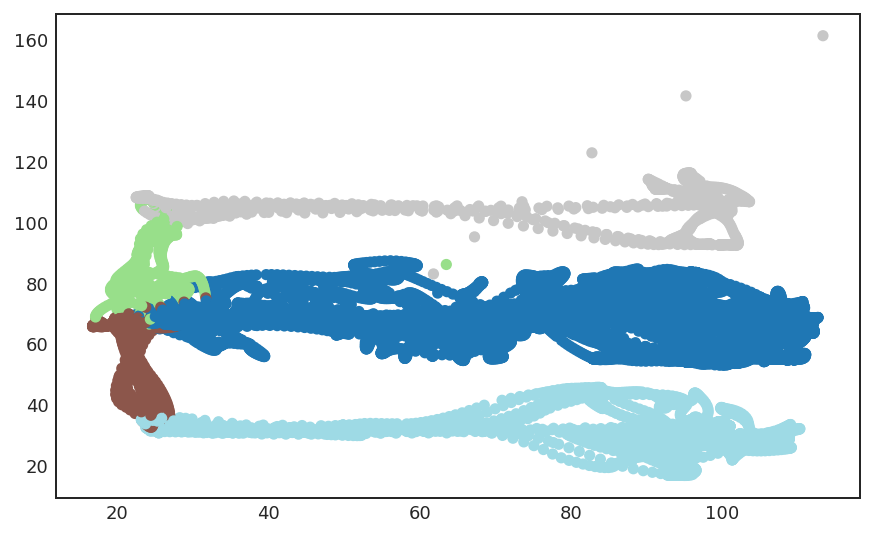

In [243]:
plt.scatter(position[:, 0], position[:, 1], c=track_segment_id, cmap=plt.cm.tab20)

In [3]:
from src.load_data import load_data

epoch_key = "con", 3, 4

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


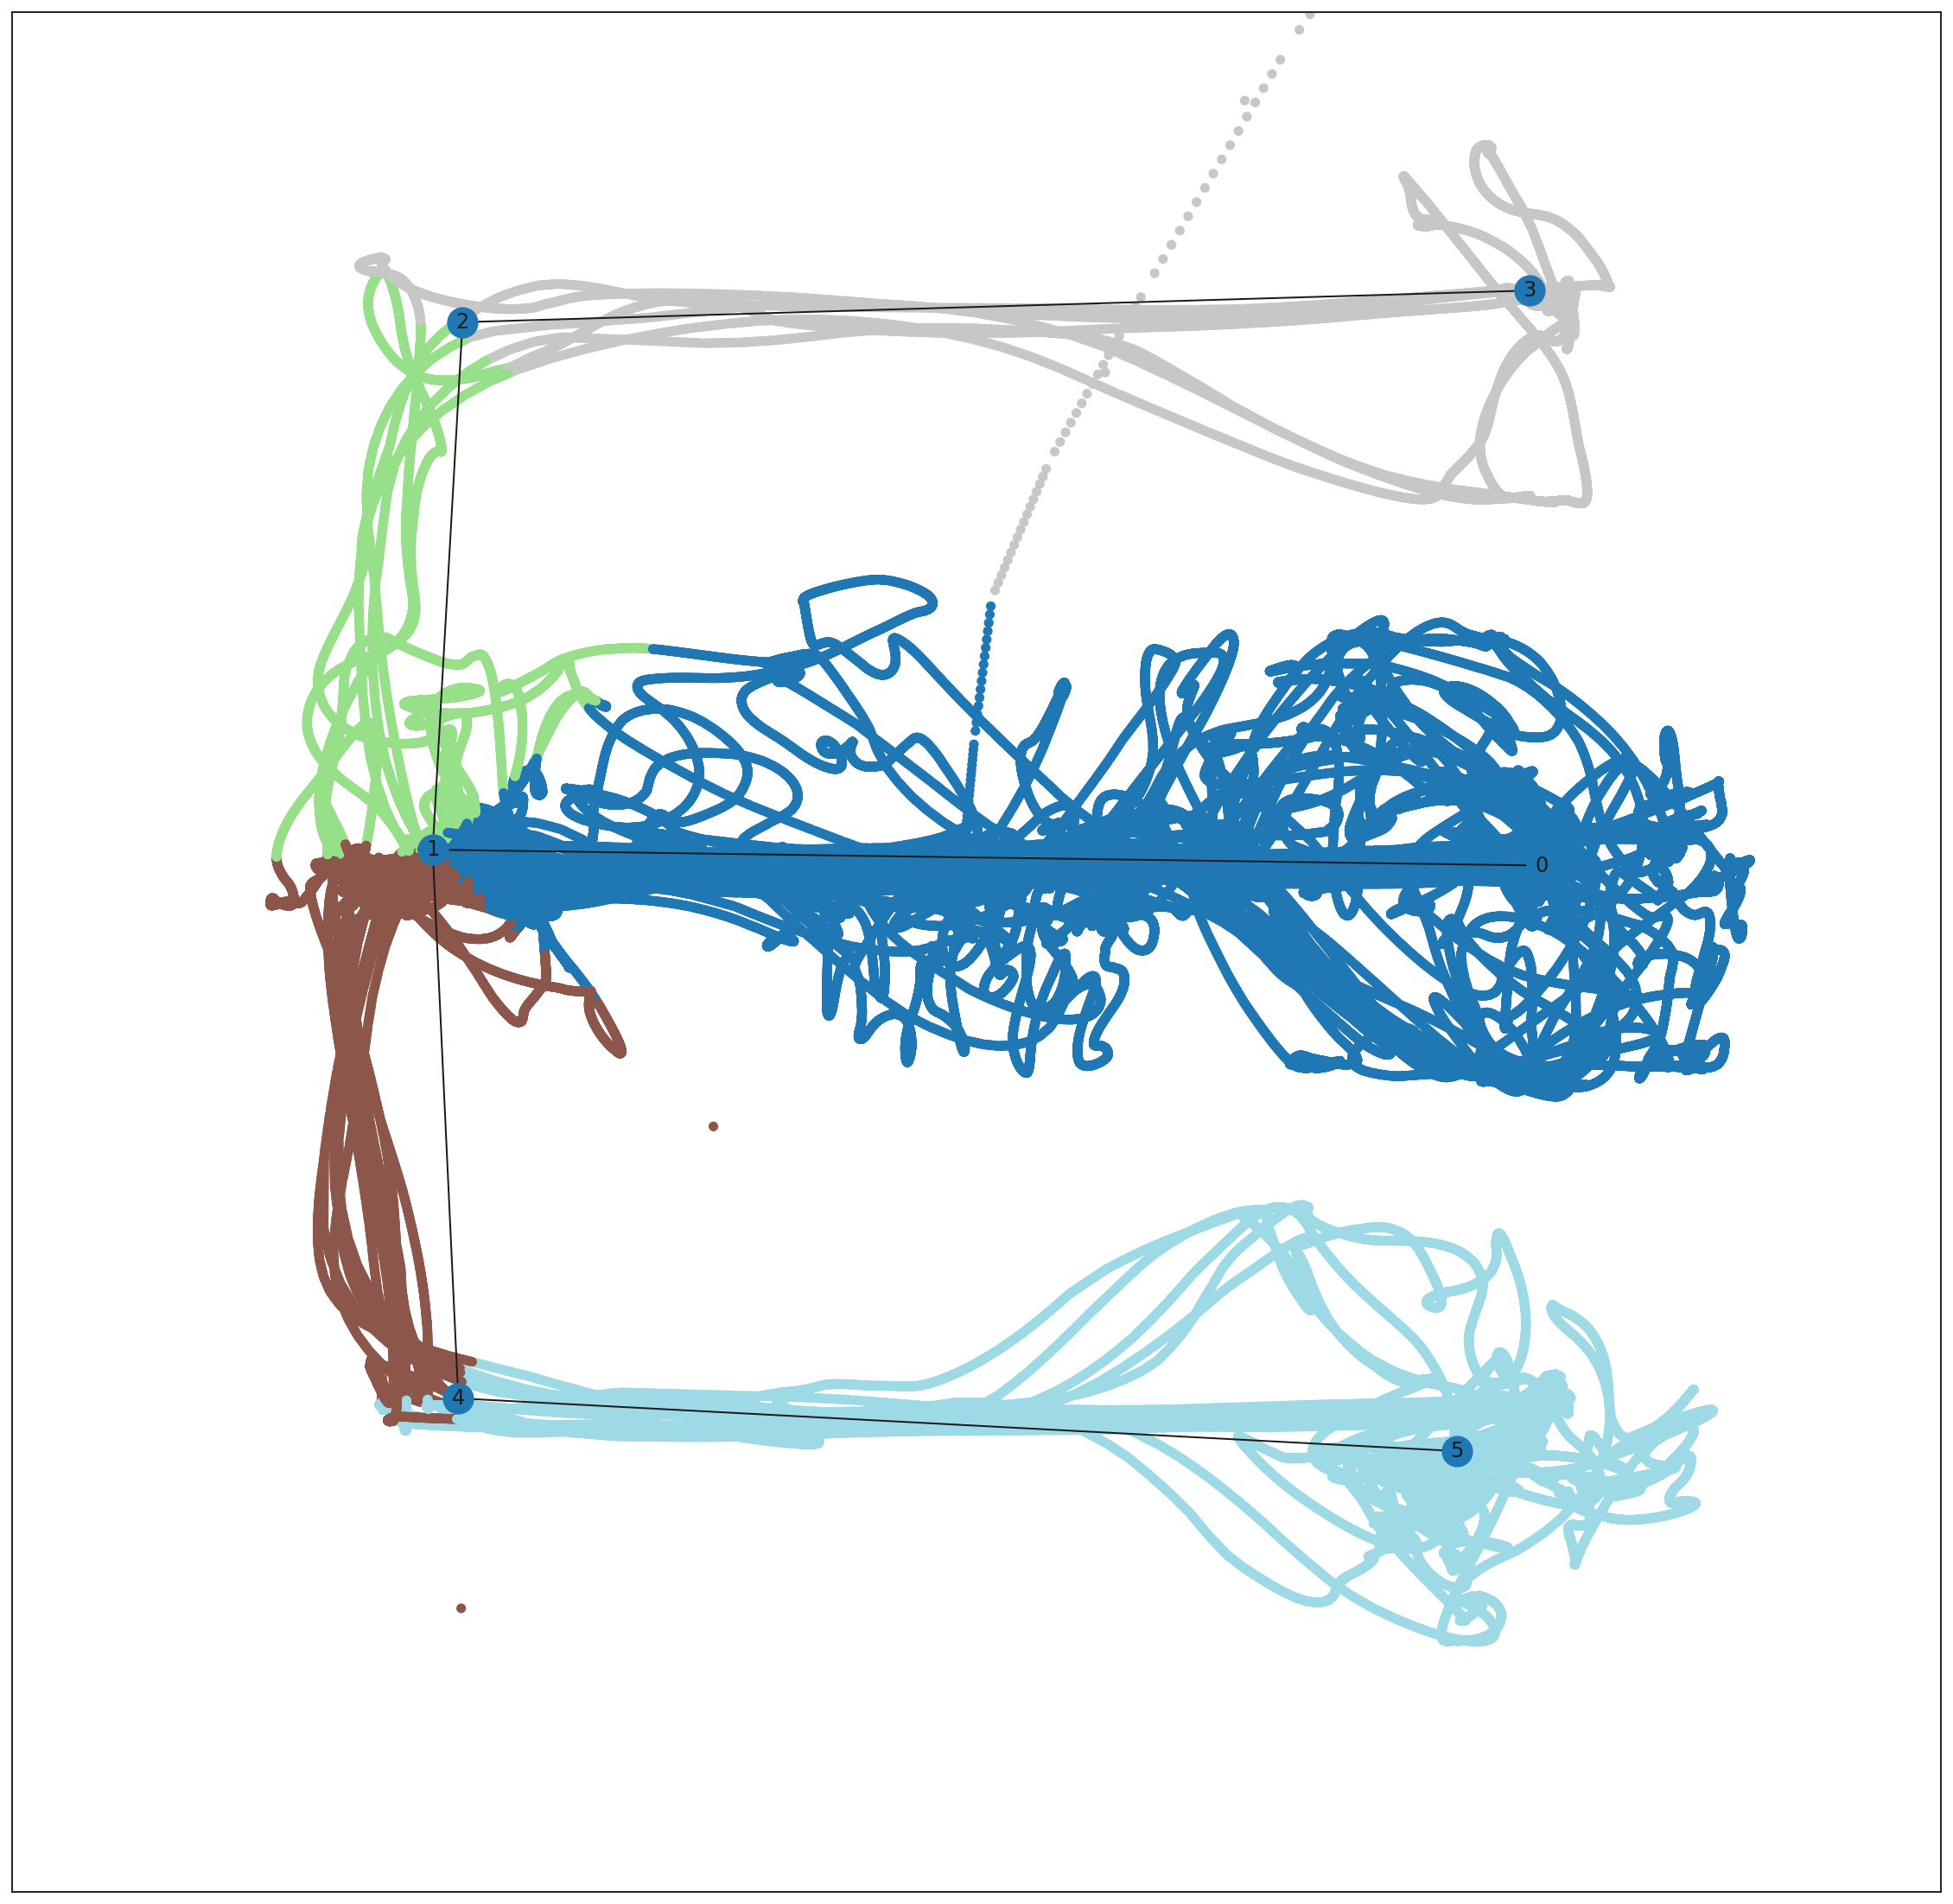

In [4]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    data["position_info"].x_position,
    data["position_info"].y_position,
    c=data["position_info"].track_segment_id,
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((0, 125))
plt.ylim((0, 125))
plot_track(track_graph)

In [10]:
from src.load_data import load_data

epoch_key = "con", 4, 2

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


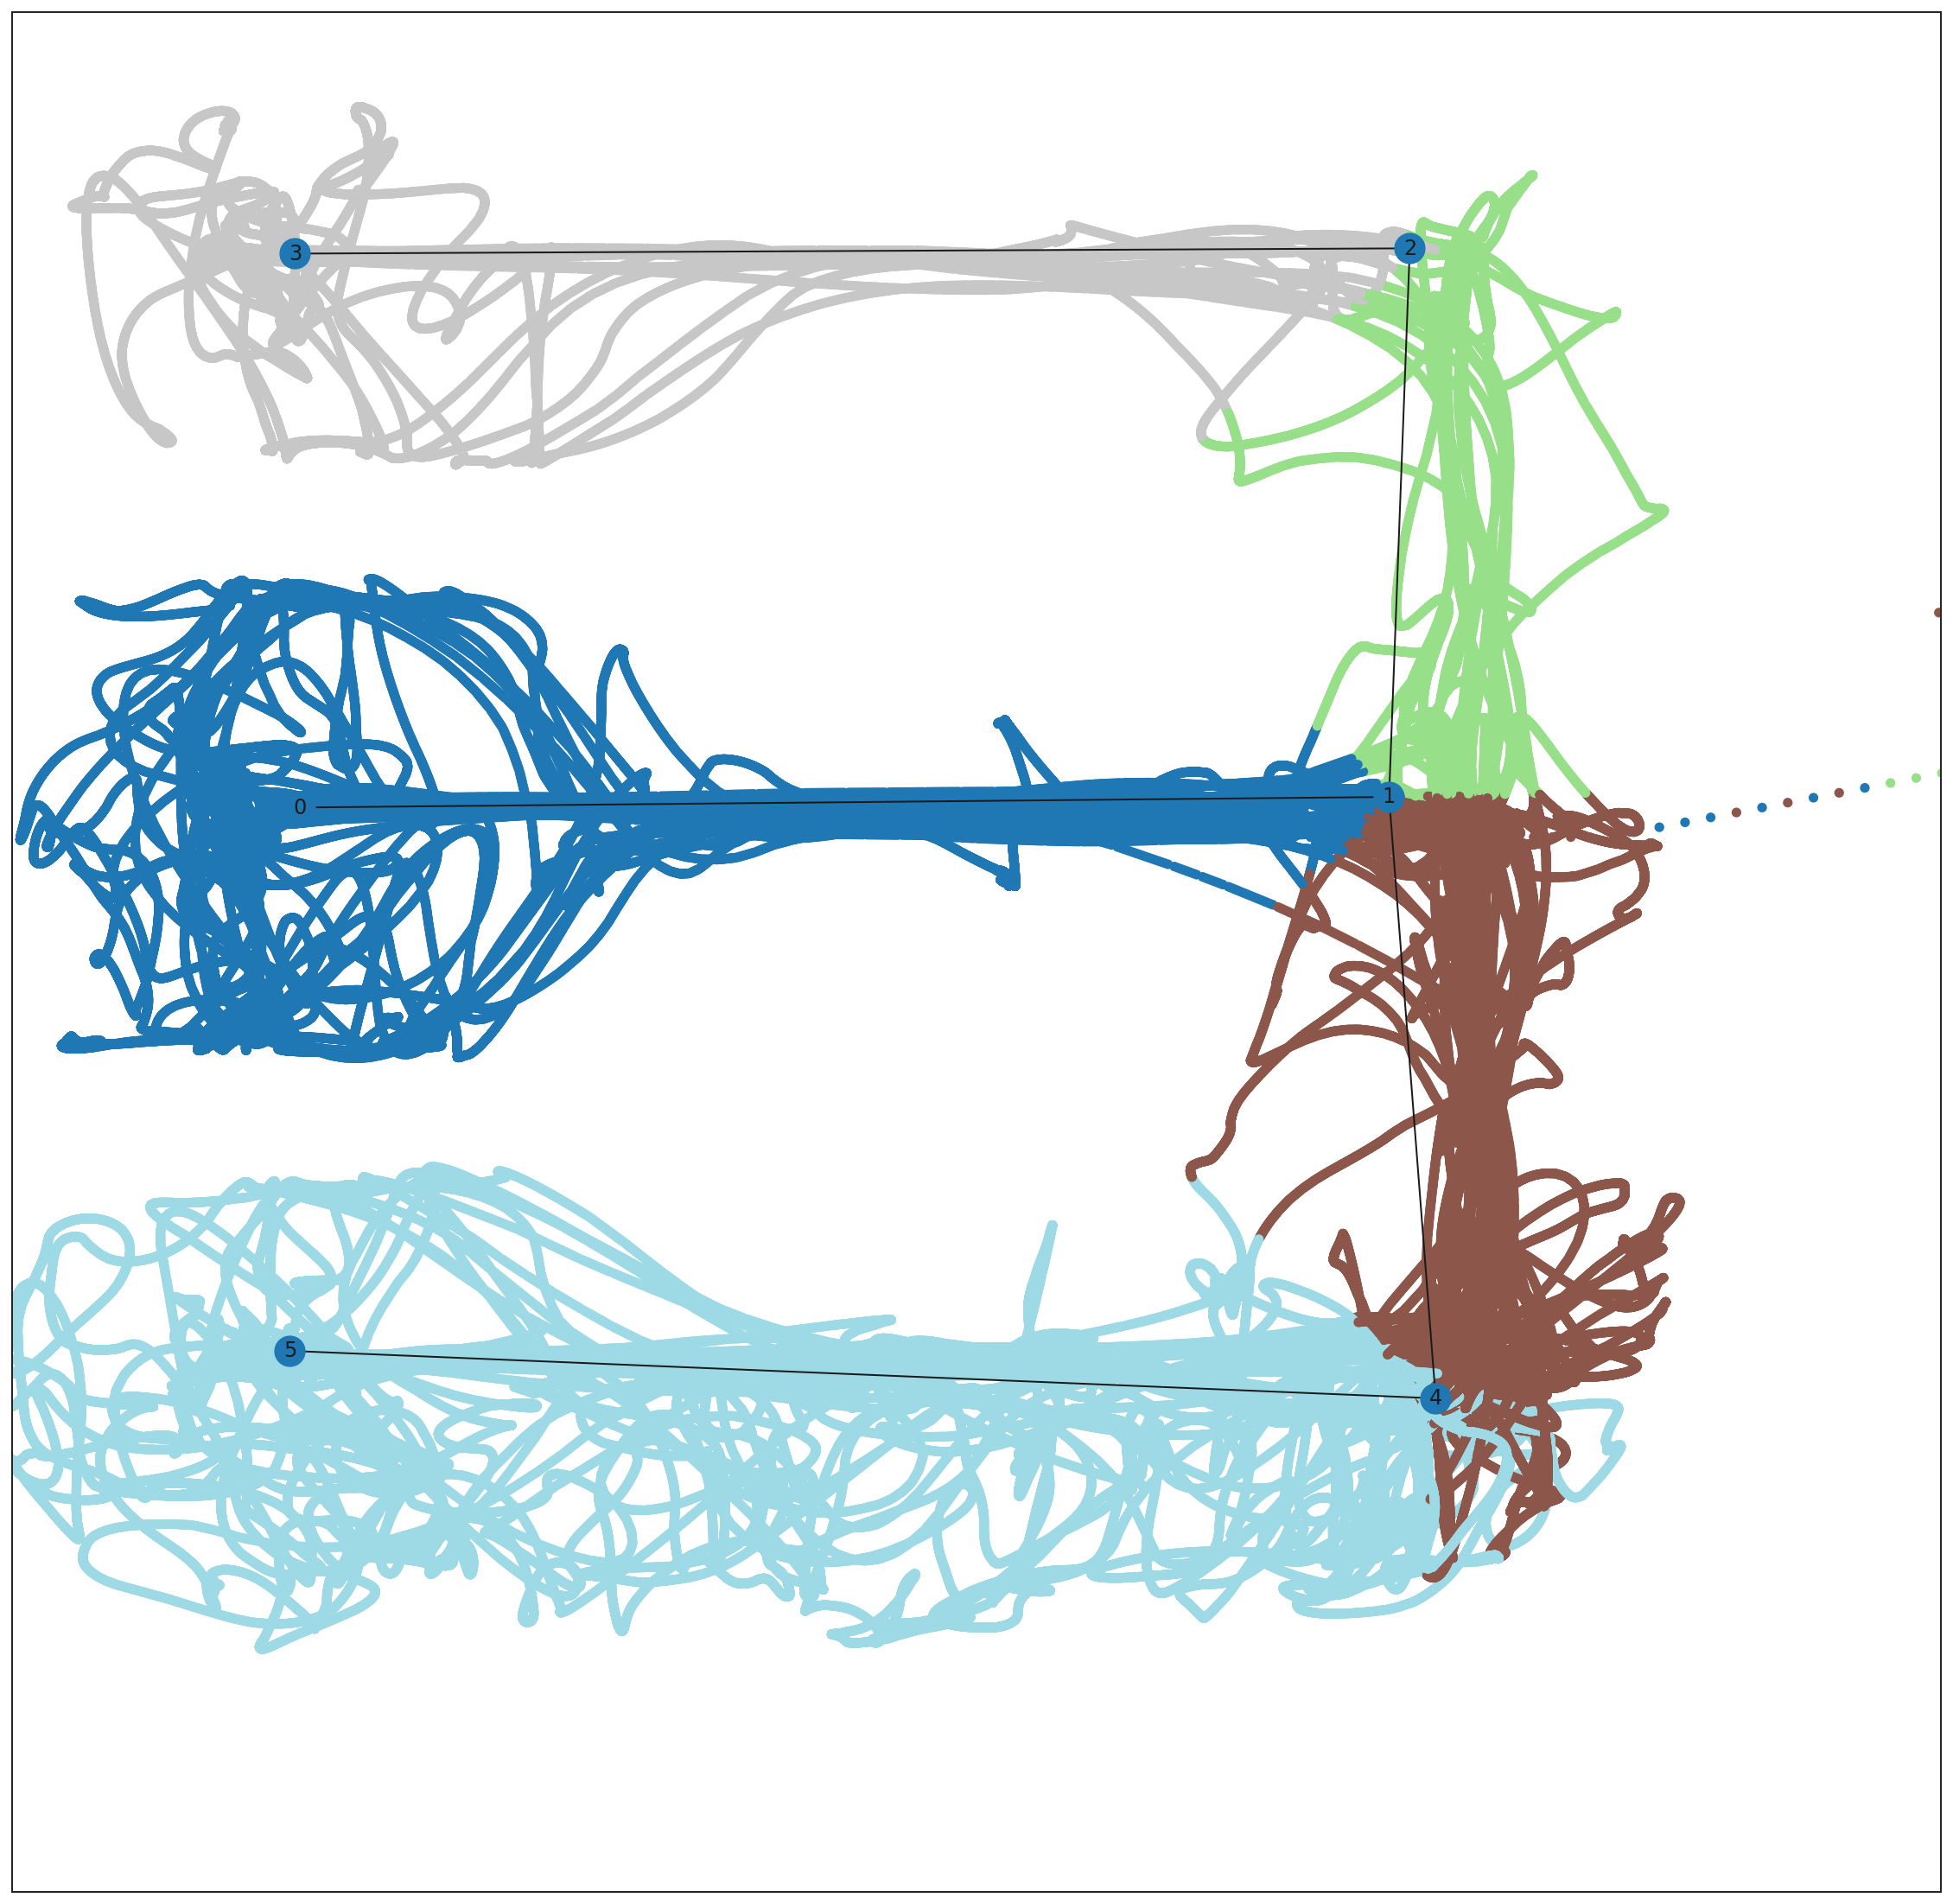

In [11]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    data["position_info"].x_position,
    data["position_info"].y_position,
    c=data["position_info"].track_segment_id,
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((120, 240))
plt.ylim((0, 125))
plot_track(track_graph)

In [7]:
from src.load_data import load_data

epoch_key = "con", 4, 4

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


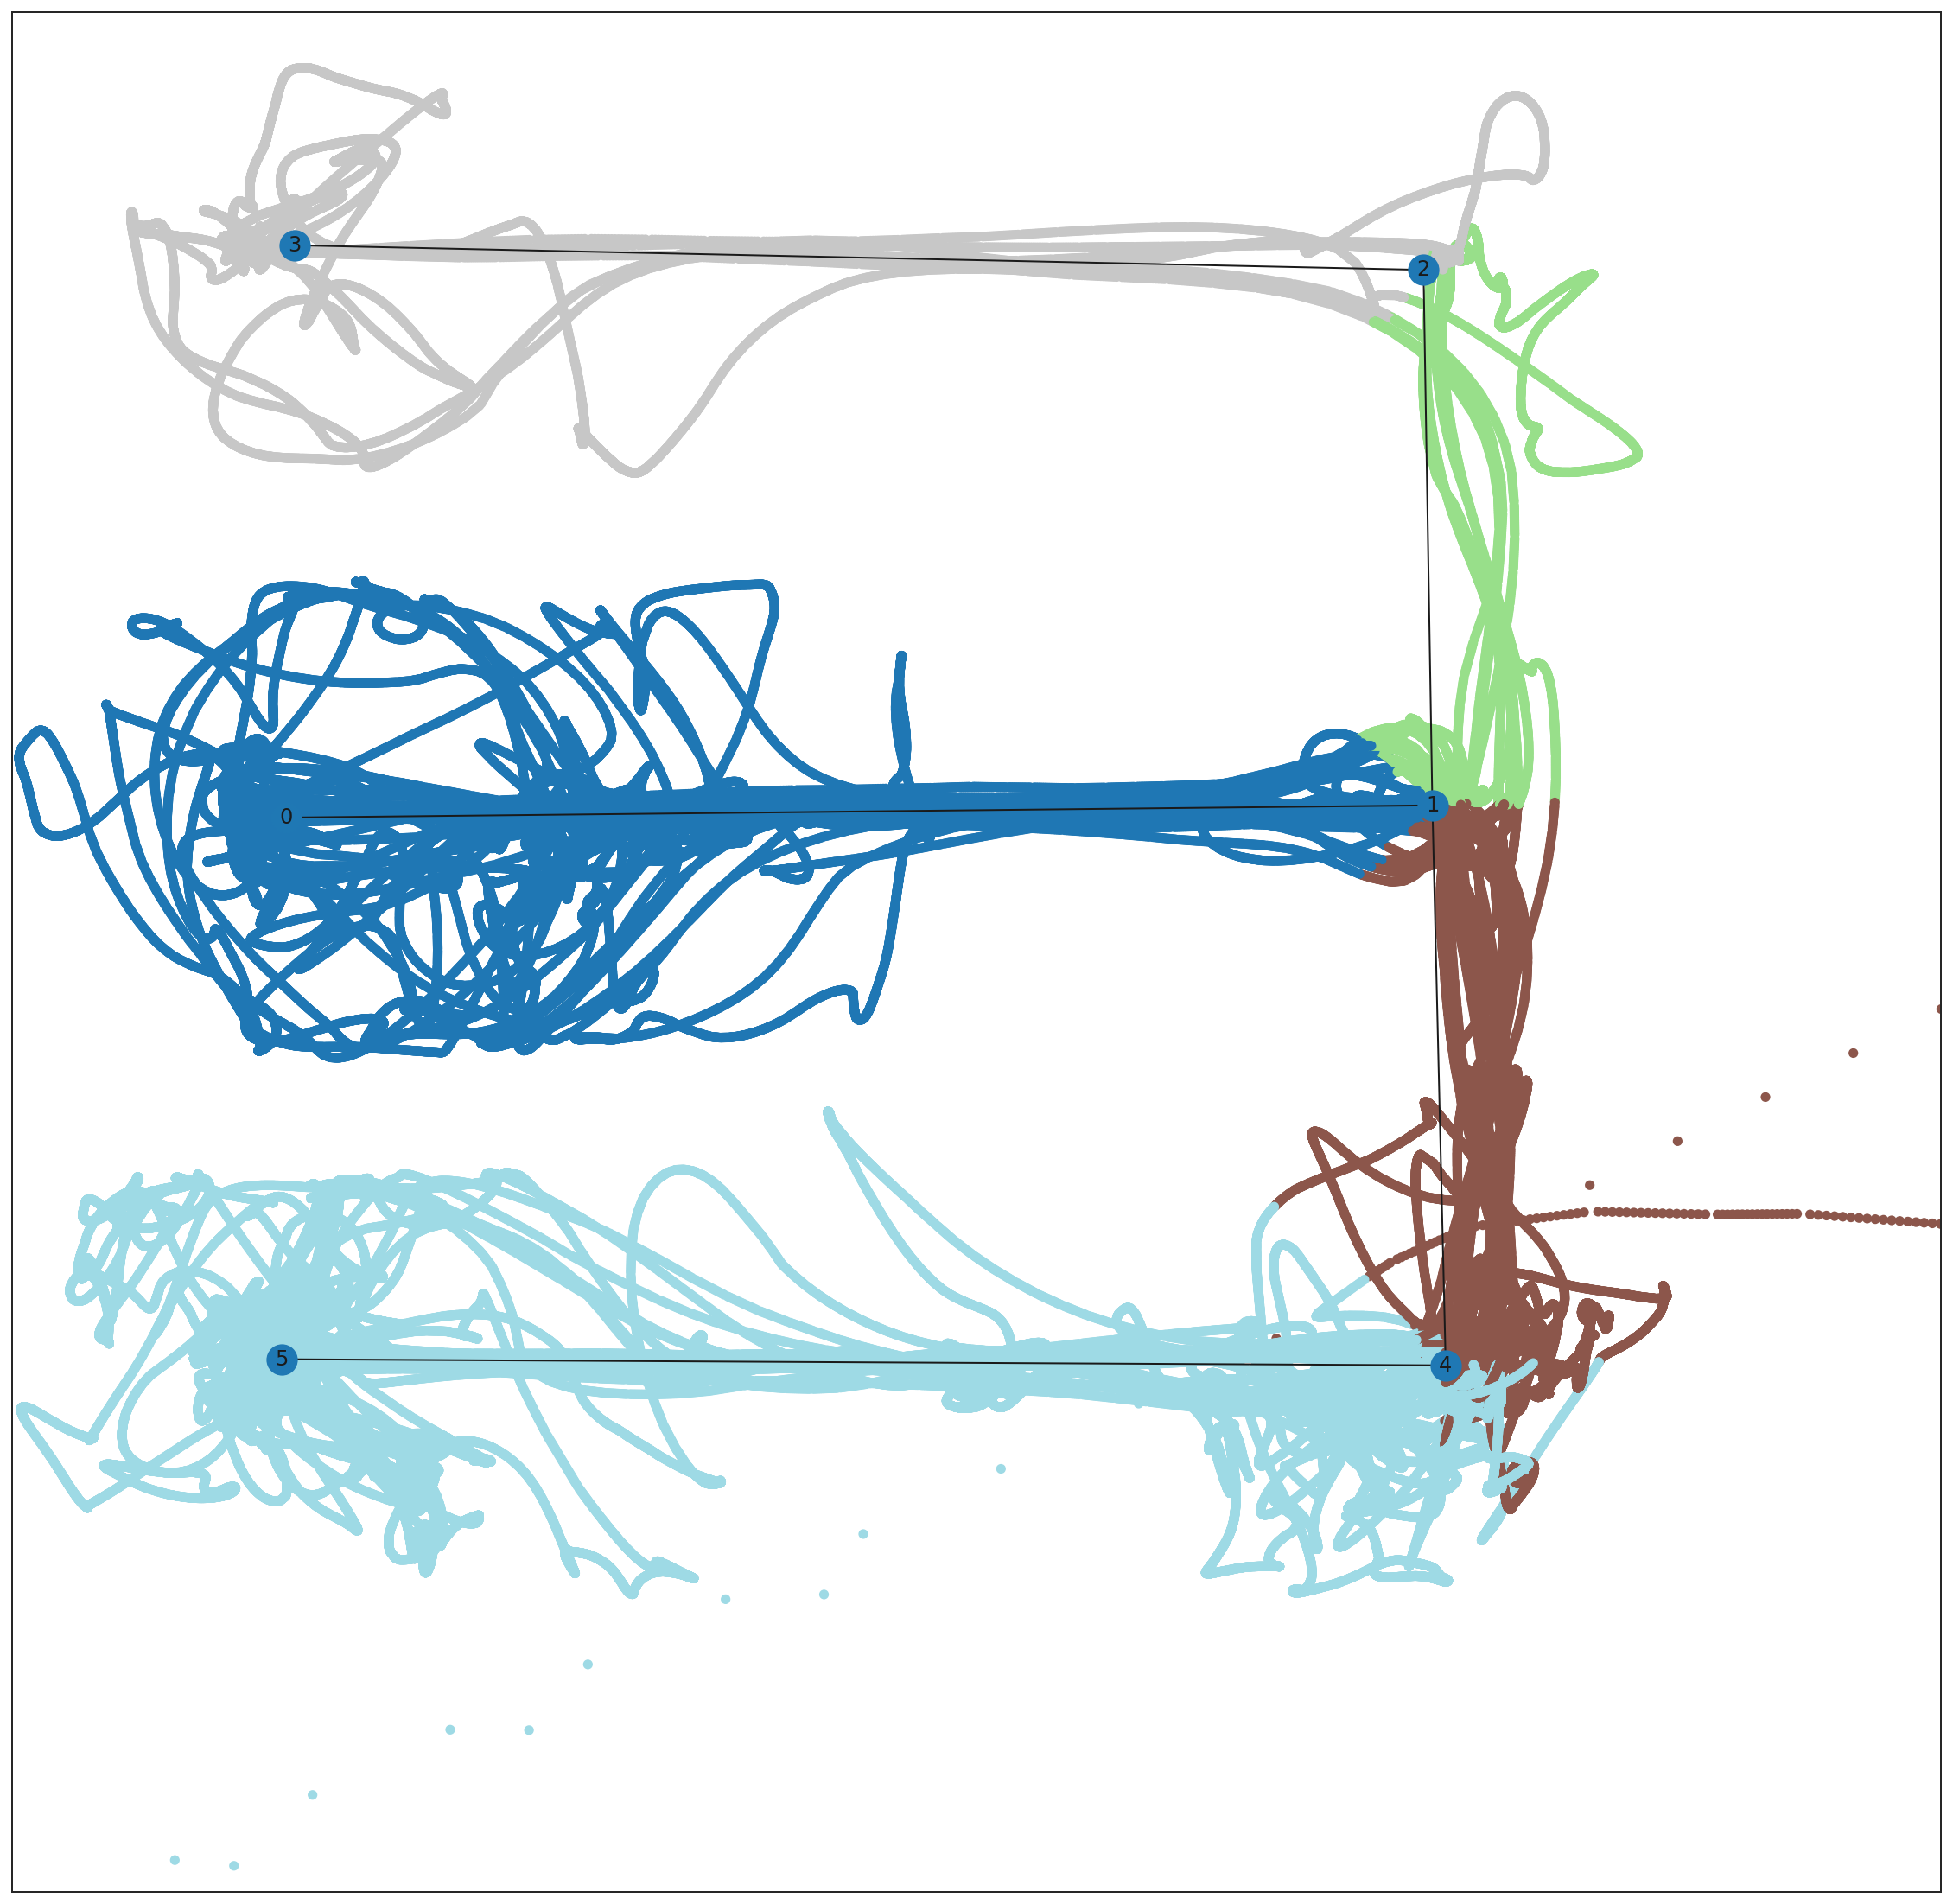

In [9]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track


plt.figure(figsize=(20, 20))
plt.scatter(
    data["position_info"].x_position,
    data["position_info"].y_position,
    c=data["position_info"].track_segment_id,
    zorder=-1,
    cmap=plt.cm.tab20,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
plt.xlim((120, 240))
plt.ylim((0, 125))
plot_track(track_graph)